# Simulating biophysically detailed multi-compartmental models using ISF

This notebook guides the user on how to use ISF to run in-silico current injection experiments using biophysically detailed full-compartmental models. The tutorial will start by specifying how to equip a cell with existing biophysical details, and continue by showing the two ways in which you can use ISF to run in-silico current injection experiments:
1. Using NEURON API, making use of dictionary-like objects that specify cell and simulation parameters. This can be useful if you want to explicitly know which information is being sent to NEURON, or if you have specific requirements on creating your own in-silico experiment setups. 
2. Using the [`Simulator`](../../../biophysics_fitting/simulator.py) and [`Evaluator`](../../../biophysics_fitting/evaluator.py) objects. These objects can be configured once per cell, and re-used for various simulation protocols.

[Tutorial 1.2: Evaluating biophysically detailed multi-compartmental models](./1.2%20Evaluation.ipynb) will show how to evaluate existing biophysically detailed compartmental models

[Tutorial 1.3: Generating biophysically detailed multi-compartmental models](./1.3%20Generation.ipynb) will use the concepts outlined in this Tutorial and Tutorial 1.2 to generate biophysically detailed compartmental models that satisfy the empirical constraints outlined in Tutorial 1.2.

In [1]:
import Interface as I
from getting_started import example_data_dir

[INFO] distributed_lock: trying to connect to distributed locking server {'config': {'hosts': 'somalogin02:33333'}, 'type': 'zookeeper'}
[INFO] distributed_lock: success!
[INFO] ISF: Current version: heads/publish+0.ga263520d.dirty
[INFO] ISF: Current pid: 136277
[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/anaconda_3.8_test2/lib/python3.8/site-packages/pandas_msgpack-0.1.4+14.gfcb0471.dirty-py3.8-linux-x86_64.egg/pandas_msgpack/packers.py:78: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import (Timestamp, Period, Series, DataFrame,  # noqa

[INFO] l5pt: Loading mechanisms:
[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/Interface.py:220: UserWarning:

The source folder has uncommited changes!


[WARNING] ISF: Could not load linked views



[INFO] ISF: Loaded modules with __version__ attribute are:
IPython: 7.19.0, Interface: heads/

## Equipping a morphology with biophysical parameters

This section will introduce a format for biophysical parameters, and how to apply them to a cell morphology using the [`single_cell_parser`](../../../single_cell_parser/__init__.py) package. We will use the layer 5 Pyramidal Tract neuron as an example application.

Which format do these parameters need to have?

In [2]:
import ast
import pprint

cell_param = I.os.path.join(
    example_data_dir,
    'biophysical_constraints',
    '86_CDK_20041214_BAC_run5_soma_Hay2013_C2center_apic_rec.param')
with open(cell_param, 'r') as f:
    params = f.read()
pprint.pp(ast.literal_eval(params))

{'info': {'name': 'hay_2011_dend_test',
          'author': 'regger',
          'date': '15Oct2014'},
 'NMODL_mechanisms': {'channels': '/'},
 'mech_globals': {},
 'neuron': {'filename': '/gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/getting_started/example_data/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc',
            'Soma': {'properties': {'Ra': 100.0,
                                    'cm': 1.0,
                                    'ions': {'ek': -85.0, 'ena': 50.0}},
                     'mechanisms': {'global': {},
                                    'range': {'pas': {'spatial': 'uniform',
                                                      'g': 3.26e-05,
                                                      'e': -90},
                                              'Ca_LVAst': {'spatial': 'uniform',
                                                           'gCa_LVAstbar': 0.00462},
                      

the variable `cell_param` is one big dictionary-like object, including information on:
- the spatial distribution of ion channels
- $Ca^{2+}$ buffering dynamics
- default simulation parameters (time interval and resolution)
- [recording site locations](../../example_data/apical_proximal_distal_rec_sites.landmarkAscii)
- passive properties (capacitance, input resistance, and reversal potentials)
- [the morphology file](../../example_data/anatomical_constraints/86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center.hoc). 

Using these parameters, we can create a [`Cell`](../../../single_cell_parser/cell.py) object, containing all the information on morphology and simulation data in a Python wrapper. For our usecase, we need to pass an additional argument to scale the apical dendrite of the L5PT with. Why this is necessary is outlined in [this notebook](../auxiliary%20notebooks/A.1%20Morphology%20Reconstruction.ipynb)

In [3]:
from simrun.utils import scale_apical

cell_param = I.scp.build_parameters(cell_param) # this is the main method to load in parameterfiles
cell = I.scp.create_cell(cell_param.neuron, scaleFunc=scale_apical)

[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/single_cell_parser/__init__.py:102: UserWarning:

Keyword scaleFunc is deprecated! New: To ensure reproducability, scaleFunc should be specified in the parameters, as described in single_cell_parser.cell_modify_funs


[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/single_cell_parser/cell_parser.py:125: UserWarning:

Keyword scaleFunc is deprecated! New: To ensure reproducability, scaleFunc should be specified in the parameters, as described in single_cell_parser.cell_modify_funs




We now have a biophysically detailed [`Cell`](../../../single_cell_parser/cell.py) object. Let's start by figuring out some general morphological properties of the example cell

In [4]:
length = sum([
    sec.L for sec in cell.sections])
dendrite_length = sum([
    sec.L for sec in cell.sections if sec.label in ['Soma', 'Dendrite', 'ApicalDendrite']])
soma_area = sum([
    sec.area for sec in cell.sections if sec.label == 'Soma'])
apic_area = sum([
    sec.area for sec in cell.sections if sec.label == 'ApicalDendrite'])


print('total length = {:.0f} micron'.format(length))
print('total dendritic length = {:.0f} micron'.format(dendrite_length))
print('soma area = {:.0f} micron^2'.format(soma_area))
print('apical dendrite area = {:.0f} micron^2'.format(apic_area))

total length = 16340 micron
total dendritic length = 15290 micron
soma area = 916 micron^2
apical dendrite area = 27212 micron^2


In [5]:
# load scaled hoc morphology
cell_param.neuron.filename = I.os.path.join(
    example_data_dir,
    'anatomical_constraints',
    '86_L5_CDK20041214_nr3L5B_dend_PC_neuron_transform_registered_C2center_scaled_diameters.hoc')
with I.silence_stdout:
    cell = I.scp.create_cell(cell_param.neuron)
print('apical dendrite area = {:.0f} micron^2'.format(sum([sec.area for sec in cell.sections \
                                                           if sec.label == 'ApicalDendrite'])))

apical dendrite area = 27212 micron^2


What does this morphology look like?

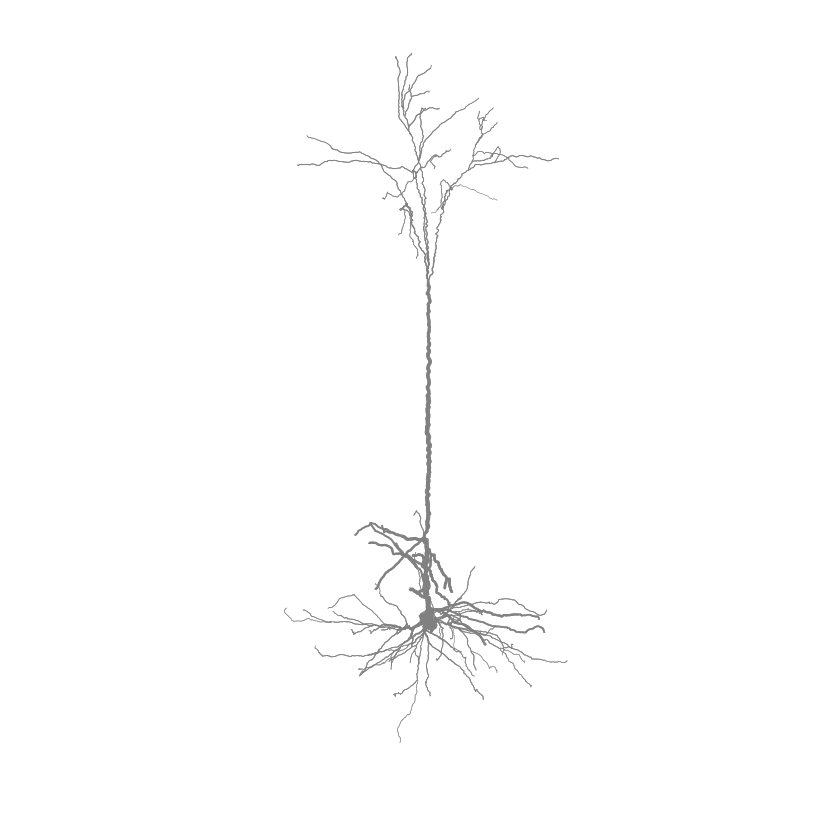

In [6]:
from visualize.cell_morphology_visualizer import CellMorphologyVisualizer
import matplotlib
%matplotlib inline
cmv = CellMorphologyVisualizer(cell)
fig = cmv.plot();

Or an interactive plot:

In [7]:
from visualize.cell_morphology_visualizer import CellMorphologyInteractiveVisualizer
cmiv = CellMorphologyInteractiveVisualizer(cell)
fig = cmiv.interactive_plot(renderer="iframe_connected");

## NEURON API

We can run simulations with this [`Cell`](../../../single_cell_parser/cell.py). We will first use the NEURON API to run current injection experiments. In the next section.

### Current injection at the soma

In [8]:
import neuron
h = neuron.h

In [9]:
iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 150 # [ms] give the cell time to reach steady state
iclamp.dur = 5 # [ms] rectangular pulse
iclamp.amp = 1.9 # [nA]
%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 

CPU times: user 1.55 s, sys: 8.22 ms, total: 1.56 s
Wall time: 1.55 s


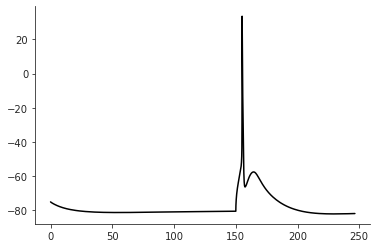

In [10]:
%matplotlib inline
I.sns.set_style('ticks')
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k');
I.sns.despine()

### Step currents at the soma

How does the cell respond to different amplitudes of the step current?

In [11]:
cell_param.sim.tStop = 3000
iclamp.dur = 2000
iclamp.delay = 500
simresult = {}
for amp in [0.619, 0.793, 1.507]:
    iclamp.amp = amp
    I.scp.init_neuron_run(cell_param.sim, vardt=True)
    simresult[amp] = I.np.array(cell.tVec), I.np.array(cell.soma.recVList[0])

[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING


[WARNING] client: Session has expired


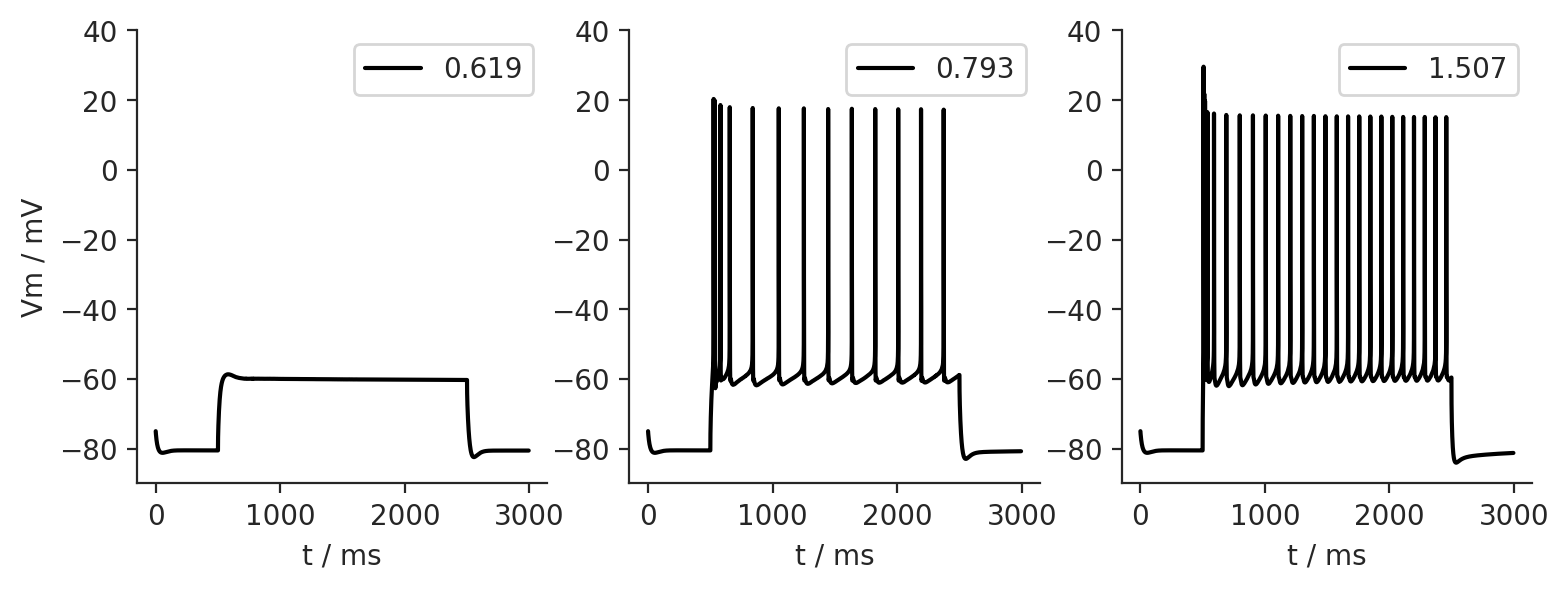

In [12]:
fig = I.plt.figure(figsize = (9,3), dpi = 200)
for lv, k in enumerate(sorted(simresult.keys())):
    ax = fig.add_subplot(1,3,lv+1)
    ax.plot(*simresult[k], label = k, c = 'k');
    ax.legend(loc = 'upper right')
    ax.set_ylim([-90, 40])
    ax.set_xlabel('t / ms')
    if lv == 0:
        ax.set_ylabel('Vm / mV')
I.sns.despine()

### Pair injection at the soma and apical dendrite

Now let's place a pipette on the apical trunk at a soma distance of 620 microns and inject current synchronously at this position and at the soma. For the current at the soma, we choose a rectangular pulse again. The current at the apical injection site should resemble the shape of a evoked post synaptic potential (epsp). Have a look at the folder mechanisms/synapses to see how epsp is implemented in hoc code.

In [13]:
# map between sections and somadistance
sec_dist_dict = {cell.distance_to_soma(sec, 1.0): sec for sec in cell.sections}

def get_section_at_distance(cell, dist):
    dummy = {k - dist: v for k,v in sec_dist_dict.items() if k > dist}
    closest_sec = dummy[min(dummy)]
    x = (dist - cell.distance_to_soma(closest_sec, 0.0)) / closest_sec.L
    return x, closest_sec

In [14]:
cell_param.sim.tStop = 500
x, sec = get_section_at_distance(cell, 620)

iclamp = h.IClamp(0.5, sec=cell.soma)
iclamp.delay = 295 # give the cell time to reach steady state
iclamp.dur = 5 # 5ms rectangular pulse
iclamp.amp = 1.9 # 1.9 ?? todo ampere

iclamp2 = h.epsp(x, sec=sec)
iclamp2.onset = 300
iclamp2.imax = 0.5
iclamp2.tau0 = 1.0 # rise time constant
iclamp2.tau1 = 5 # decay time constant
cell.iclamp2 = iclamp2

%time I.scp.init_neuron_run(cell_param.sim, vardt=True) # run the simulation 

CPU times: user 3.1 s, sys: 28 ms, total: 3.13 s
Wall time: 3.11 s


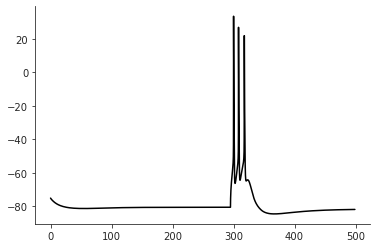

In [15]:
I.plt.plot(cell.tVec, cell.soma.recVList[0], c = 'k');
I.sns.despine()

## The ISF [`Simulator`](../../../biophysics_fitting/simulator.py)

This Section will provide a walkthrough on how to interact with the biohysical properties of a cell using the [`Simulator`](../../../biophysics_fitting/simulator.py) object. This object can be configured once per cell, and re-used for various simulation protocols. It operates on biophysical parameters of the `pandas.dataFrame` type.

### Biophysical parameters (revisited)

In [16]:
# Load example biophysical models
db_path = I.os.path.join(example_data_dir, 'simulation_data', 'biophysics')
db = I.DataBase(db_path)

example_models = db['example_models']
# resolve pathnames to your local machine
example_models['morphology.filename'] = [I.os.path.join(
   example_data_dir, 'anatomical_constraints', e) for e in example_models['morphology.filename']]

In [17]:
# parameter names
biophysical_parameters = [e for e in example_models.columns if "ephys" in e or e == "scale_apical.scale"]

Let's inspect what these biophysical parameters look like

In [18]:
# get the biophysical parameters of one examplary biophysical model
p = example_models.iloc[0][biophysical_parameters]
p

ephys.CaDynamics_E2_v2.apic.decay        59.0477
ephys.CaDynamics_E2_v2.apic.gamma     0.00112918
ephys.CaDynamics_E2_v2.axon.decay        743.739
ephys.CaDynamics_E2_v2.axon.gamma     0.00121861
ephys.CaDynamics_E2_v2.soma.decay        159.292
ephys.CaDynamics_E2_v2.soma.gamma      0.0137903
ephys.Ca_HVA.apic.gCa_HVAbar          0.00376466
ephys.Ca_HVA.axon.gCa_HVAbar         0.000280338
ephys.Ca_HVA.soma.gCa_HVAbar         4.83005e-05
ephys.Ca_LVAst.apic.gCa_LVAstbar        0.194205
ephys.Ca_LVAst.axon.gCa_LVAstbar      0.00674865
ephys.Ca_LVAst.soma.gCa_LVAstbar     5.23378e-06
ephys.Im.apic.gImbar                 0.000758139
ephys.K_Pst.axon.gK_Pstbar              0.367934
ephys.K_Pst.soma.gK_Pstbar            0.00192893
ephys.K_Tst.axon.gK_Tstbar             0.0185365
ephys.K_Tst.soma.gK_Tstbar             0.0831176
ephys.NaTa_t.apic.gNaTa_tbar           0.0185236
ephys.NaTa_t.axon.gNaTa_tbar             3.66734
ephys.NaTa_t.soma.gNaTa_tbar              1.7436
ephys.Nap_Et2.axon.g

Apart from the passive properties, we have 35 biophysical parameters, relating to varying biophysical aspects for the soma, axon (AIS), apical dendrite, and other dendrites (taken to be passive for current injection experiments).

|Name|Meaning|Unit|
|---|---|---|
|ephys.X.\<location\>.gXbar| Density of Hodgkin Huxley-type channel X |[$S/cm^2$]|
|scale_apical.scale|Scaling factor for the diameter of the apical dendrite|None|
|ephys.CaDynamics_E2_v2.\<location\>.gamma| Ratio of free $Ca^{2+}$ | None|
|ephys.CaDynamics_E2_v2.\<location\>.gamma | Time constant of first-order dynamic $Ca^{2+}$-buffering| [$ms$]|
|ephys.SKv3_1.apic.offset/slope|Distribution parameters of $SKv3.1$ channels|[$\mu m$]/None|

### The [Simulator](../../../biophysics_fitting/simulator.py)

Here, we introduce the [`Simulator`](../../../biophysics_fitting/simulator.py) object, specific to a particular morphology.


A full workflow on how to set up a Simulator generally looks like:

```python
s = Simulator() # instantiate simulator object
s.setup # Simulator_Setup object, that contains all elements defining the pipeline above
s.setup.cell_param_generator =  example_cell_param_template_generator
s.setup.cell_generator = cell_generator
s.setup.params_modify_funs.append('name_of_param_modify_fun', example_cell_param_modify_function)
s.setup.cell_param_modify_funs.append('name_of_cell_param_modify_fun', example_cell_param_modify_function)
s.setup.cell_modify_funs.append('name_of_cell_modify_fun', example_cell_modify_function)
```

This section guides you through how to set up such a Simulator yourself.

In [19]:
def get_example_fixed_params(db, key):
    p = db[key]['get_fixed_params'](db[key])
    return p

To set up a Simulator, you need morphology-specific fixed parameters. We will use a new morphology for this, with the ID "89".

In [20]:
fixed_params = get_example_fixed_params(db, '89')
pprint.pp(fixed_params)

{'BAC.hay_measure.recSite': 294.8203371921156,
 'BAC.stim.dist': 294.8203371921156,
 'bAP.hay_measure.recSite1': 294.8203371921156,
 'bAP.hay_measure.recSite2': 474.8203371921156,
 'hot_zone.min_': 384.8203371921156,
 'hot_zone.max_': 584.8203371921156,
 'hot_zone.outsidescale_sections': [23,
                                    24,
                                    25,
                                    26,
                                    27,
                                    28,
                                    29,
                                    31,
                                    32,
                                    33,
                                    34,
                                    35,
                                    37,
                                    38,
                                    40,
                                    42,
                                    43,
                                    44,
                          

These parameters define recording locations for stimuli, and some celltype-specific variables. In our case of an L5PT, it also defines the "hotzone": a small section of apical dendrite near the bifurcation zone that has a high density of $Ca^{2+}$ channels. Each L5PT morphology also has a free parameter to scale the diameter of the apical dendrite. This is added to the `fixed_params` as an additional modification method. Usually, big parts of such setup can be re-used for different morphologies, simulations etc. The setup below will highlight which parts are specific to the celltype, the cell, or the biophysical details of a single cell.

The full setup of a Simulator object for running Hay's protocols on an L5PT is given in [`biophysics_fitting.hay_complete_default_setup.get_Simulator()`](../../../biophysics_fitting/hay_complete_default_setup.py).

In [21]:
from biophysics_fitting.hay_complete_default_setup import get_Simulator
from biophysics_fitting.L5tt_parameter_setup import get_L5tt_template_v2

def scale_apical(cell_param, params):
    assert(len(params) == 1)
    cell_param.cell_modify_functions.scale_apical.scale = params['scale']
    return cell_param

s = get_Simulator(fixed_params)
s.setup.cell_param_generator = get_L5tt_template_v2
s.setup.cell_param_modify_funs.append(('scale_apical', scale_apical))

We now have a Simulator object with morphology-specific `fixed_params`.

For a Simulator object `s`, the main functions are:

|Method|Output|
|---|---|
|`s.run(params)`| a dictionary with the specified voltagetraces for all stimuli|
|`s.get_simulated_cell(params, stim)`| params and cell object for stimulus stim|
|`s.setup.get(params)`|a cell with set up biophysics|
|`s.setup.get_cell_params(params)`| cell NTParameterSet structure used for the single_cell_parser.create_cell. This is helpful for inspecting, what parameters have effectively been used for the simulation|
|`s.setup.get_cell_params_with_default_sim_prams(params, ...)`| complete neuron parameter filethat can be used for further simulations, i.e. with the simrun module or with roberts scripts.|

#### The $bAP$ stimulus

The $bAP$ stimulus protocol is a step current injection at the soma, strong enough to evoke a backpropagating action potential (bAP)

In [22]:
cell, param = s.get_simulated_cell(p, 'bAP')

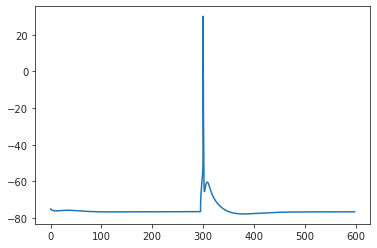

In [23]:
%matplotlib inline
I.plt.plot(cell.tVec, cell.sections[0].recVList[0])

#### The $BAC$ stimulus protocol

A $BAC$ stimulus is a $bAP$ stimulus, with a well-timed epsp-shaped current injection at the apical dendrite. $BAC$ here stands for $bAP$-activated $Ca^{2+}$-spike

Where exactly do we inject the epsp-shaped apical current? We already saved this information in `fixed_params`. Morphology "89" has a rather deep bifurcation, so the epsp injection is at only $295\mu m$ from the soma.

In [24]:
fixed_params['BAC.stim.dist']

294.8203371921156

In [25]:
cell, p = s.get_simulated_cell(p, 'BAC')

[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING


[WARNING] client: Session has expired


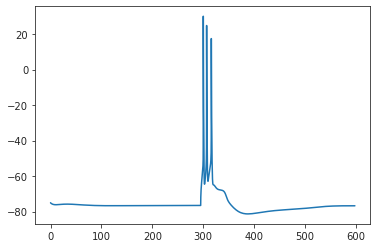

In [26]:
%matplotlib inline
I.plt.plot(cell.tVec, cell.sections[0].recVList[0])

parallelMovieMaker
files are here: animation/animation_ab2ccw36/*.png



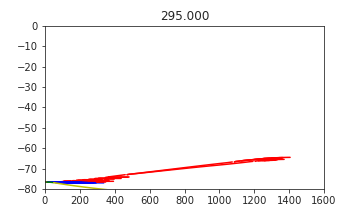
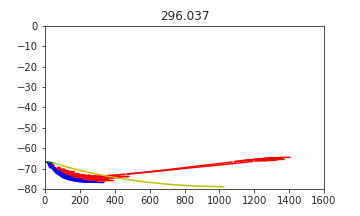
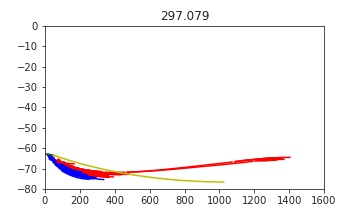
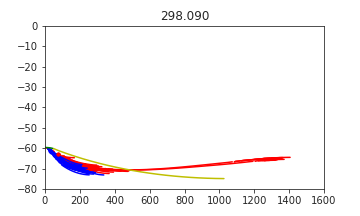
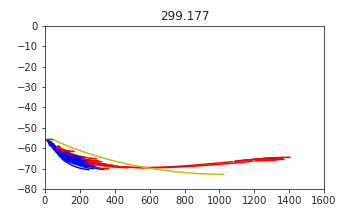
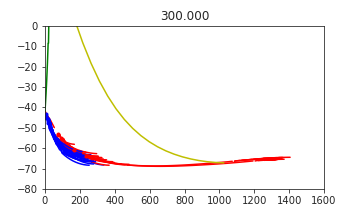
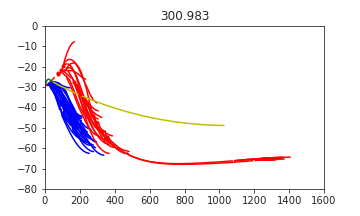
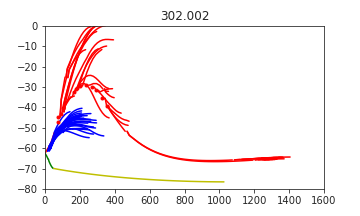
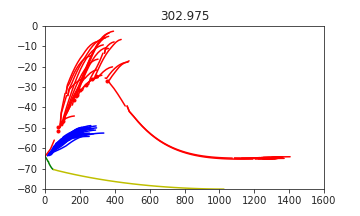
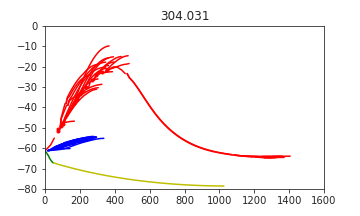
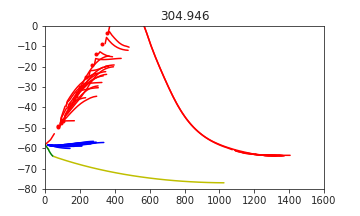
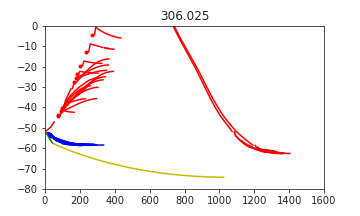
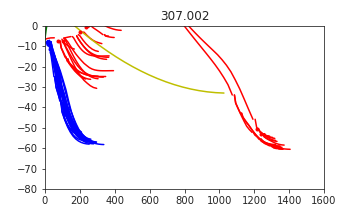
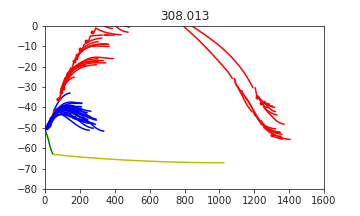
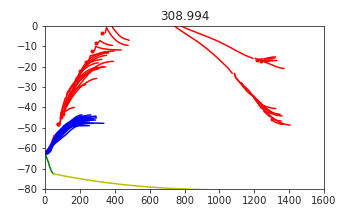
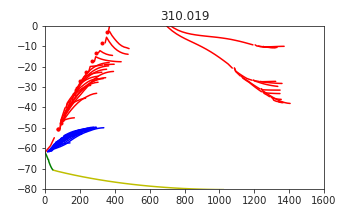
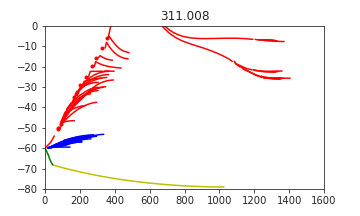
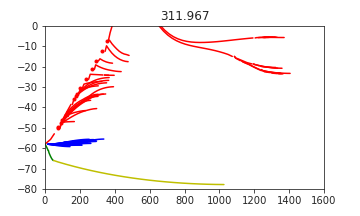
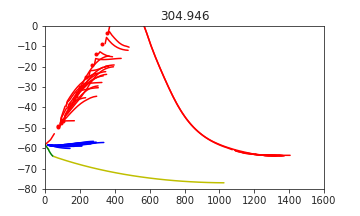
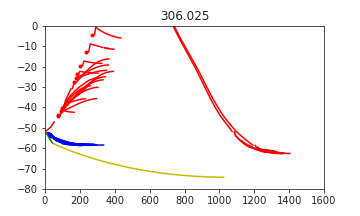
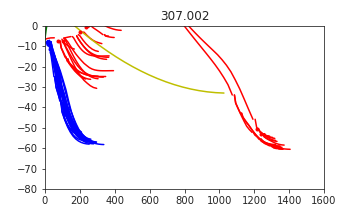
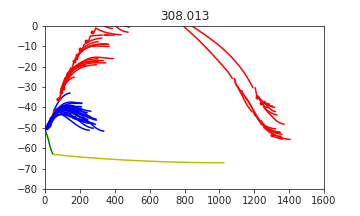
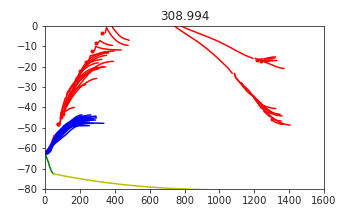
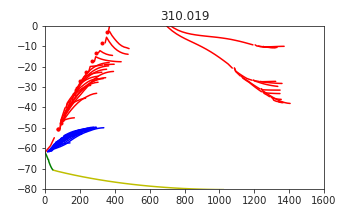
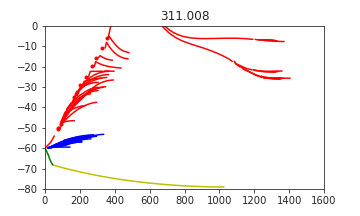
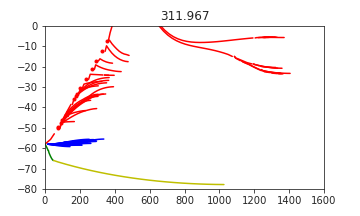
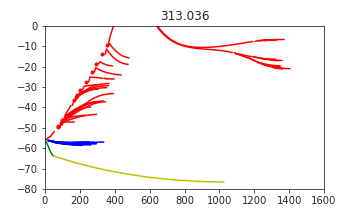
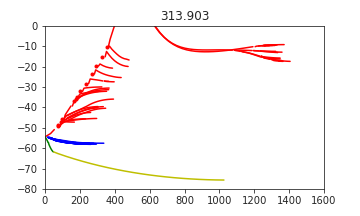
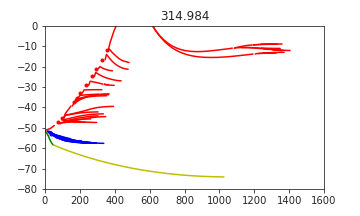
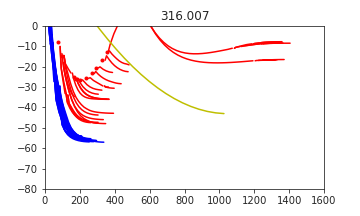
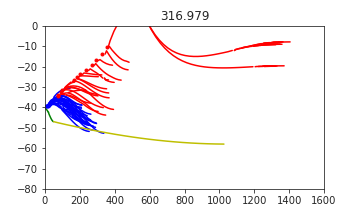
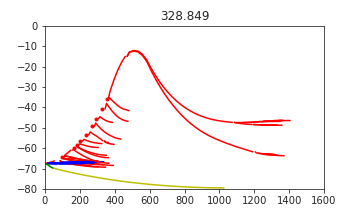
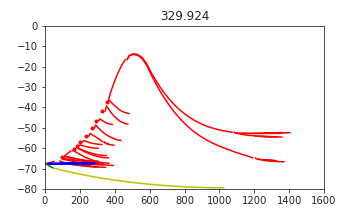
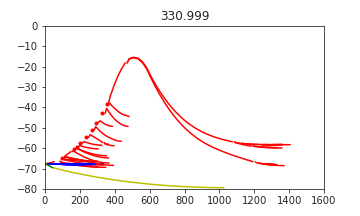
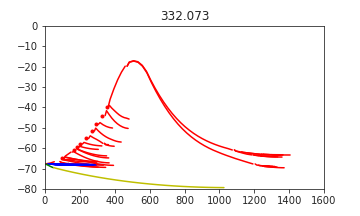
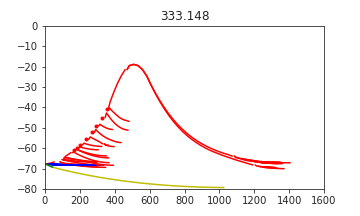
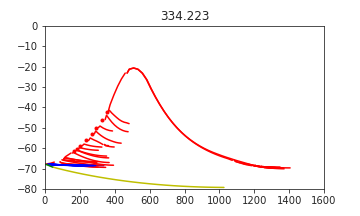
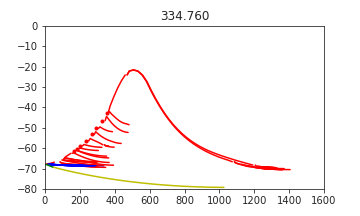
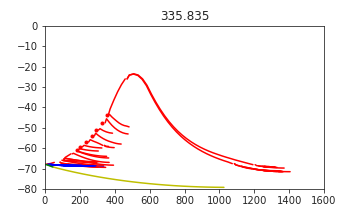
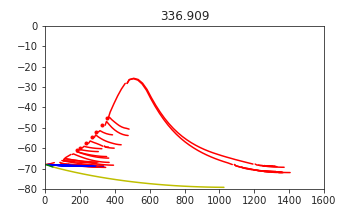
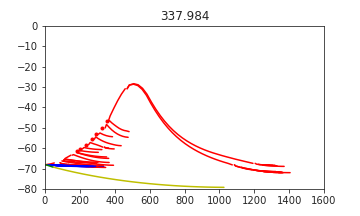
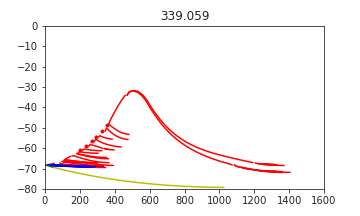
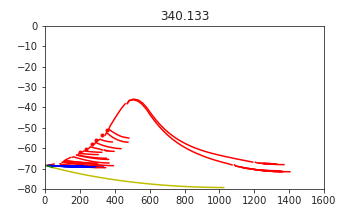
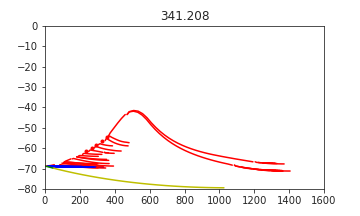
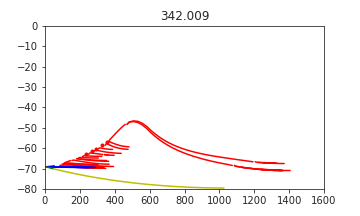
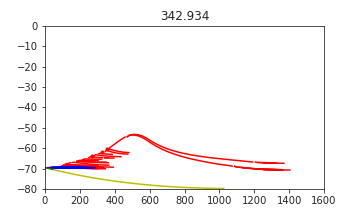
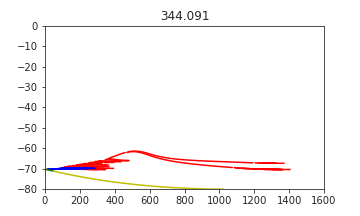
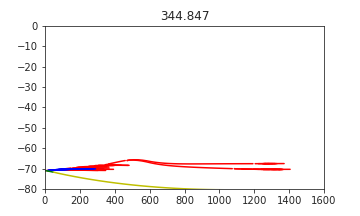
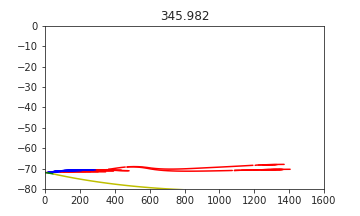
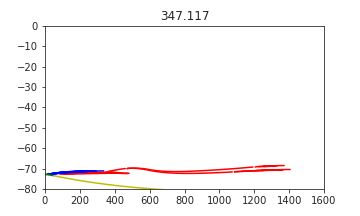
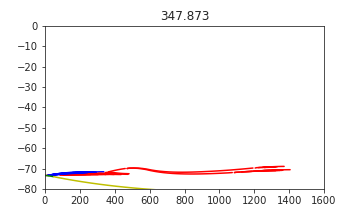
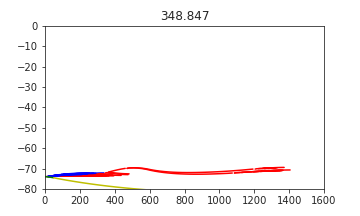

In [27]:
I.cell_to_ipython_animation(
    cell, 
    tstart=295, 
    tend=350, 
    embedded=True)

In [28]:
from importlib import reload
reload(I)
import Interface as I

[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/project_src/in_silico_framework/Interface.py:220: UserWarning:

The source folder has uncommited changes!


[WARNING] ISF: Could not load linked views





[WARNING] warnings: /gpfs/soma_fs/scratch/meulemeester/anaconda_3.8_test2/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning:

Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| tornado | 6.0.4  | 6.4       | 6.4     |
+---------+--------+-----------+---------+





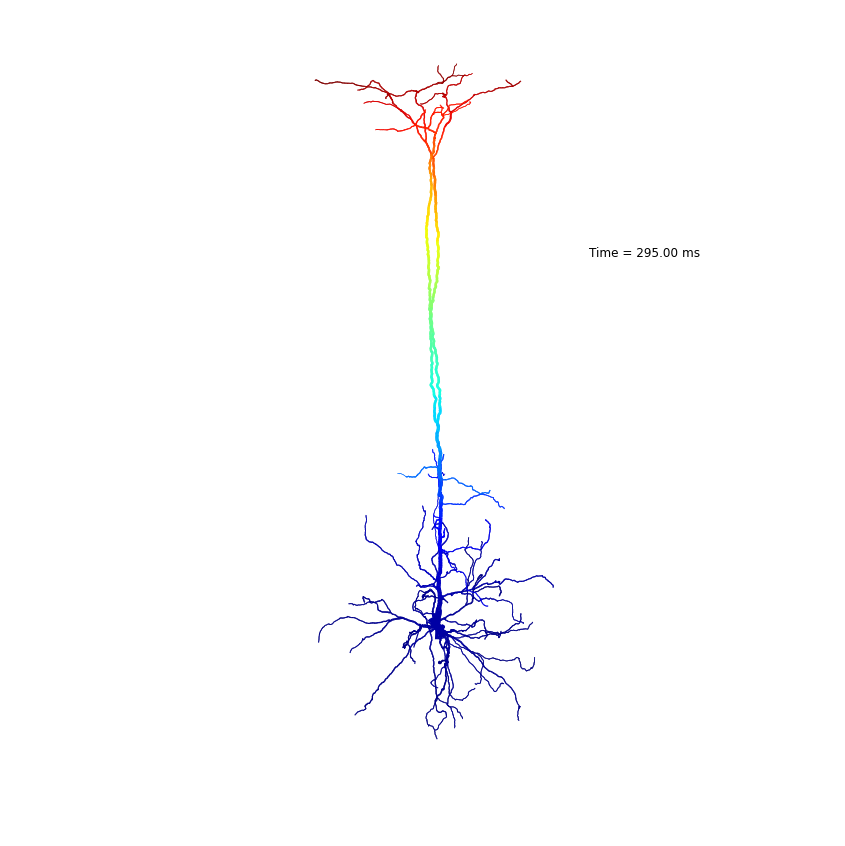
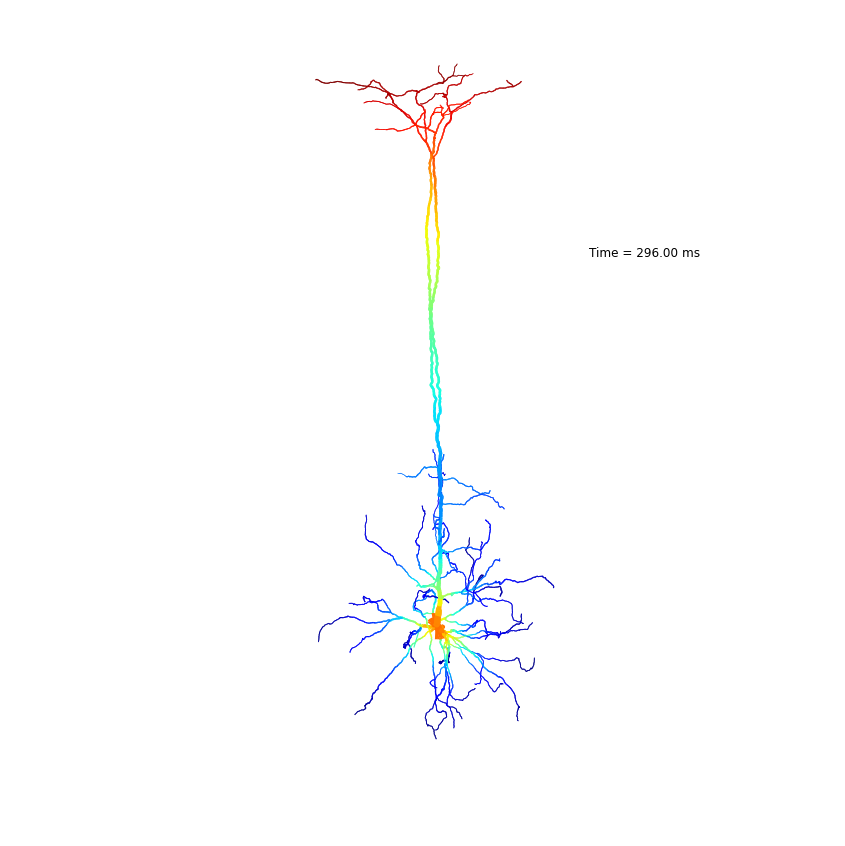
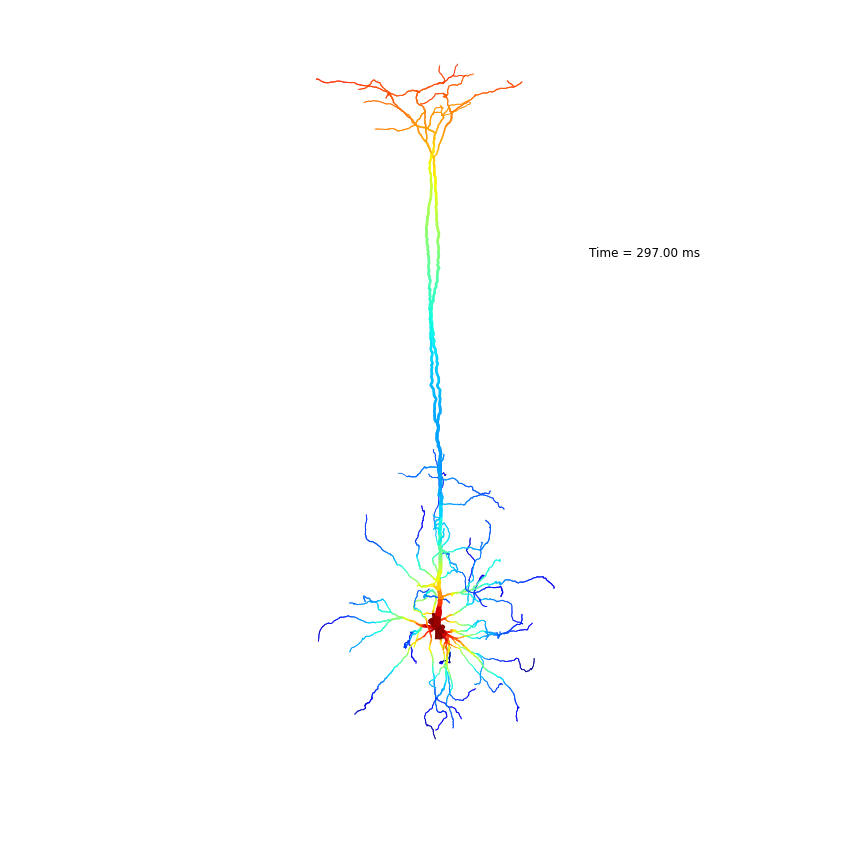
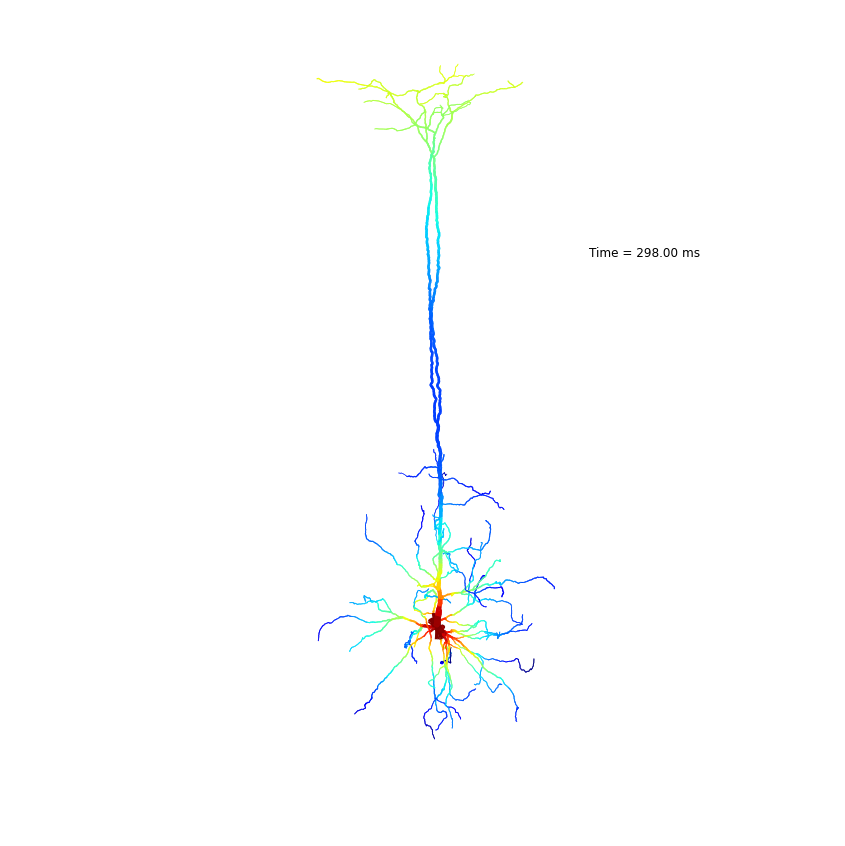
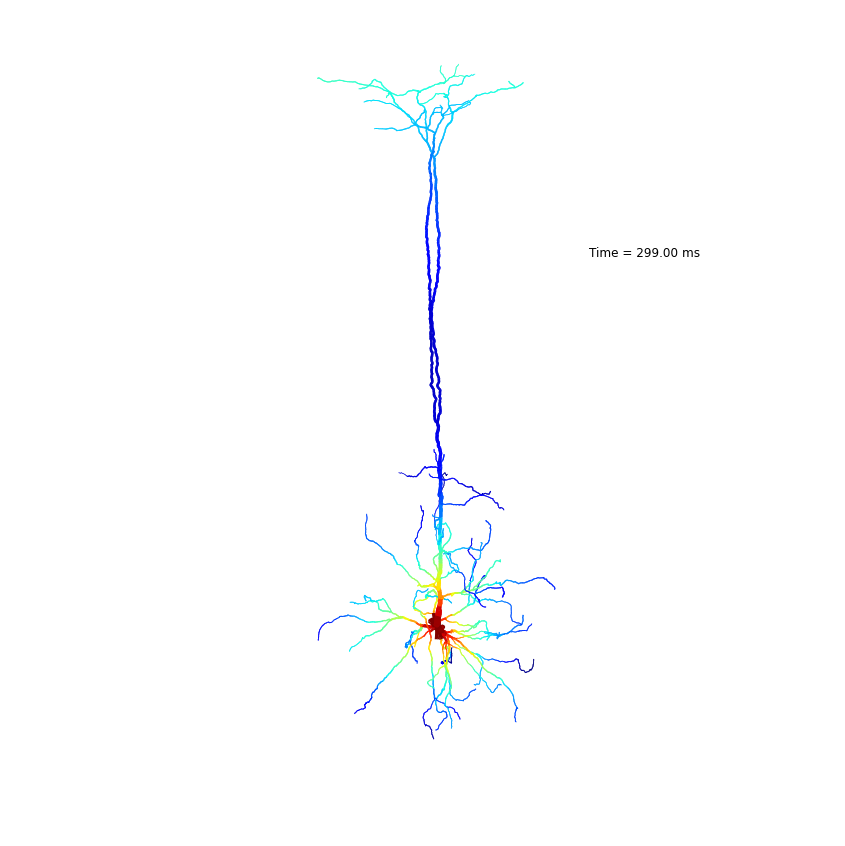
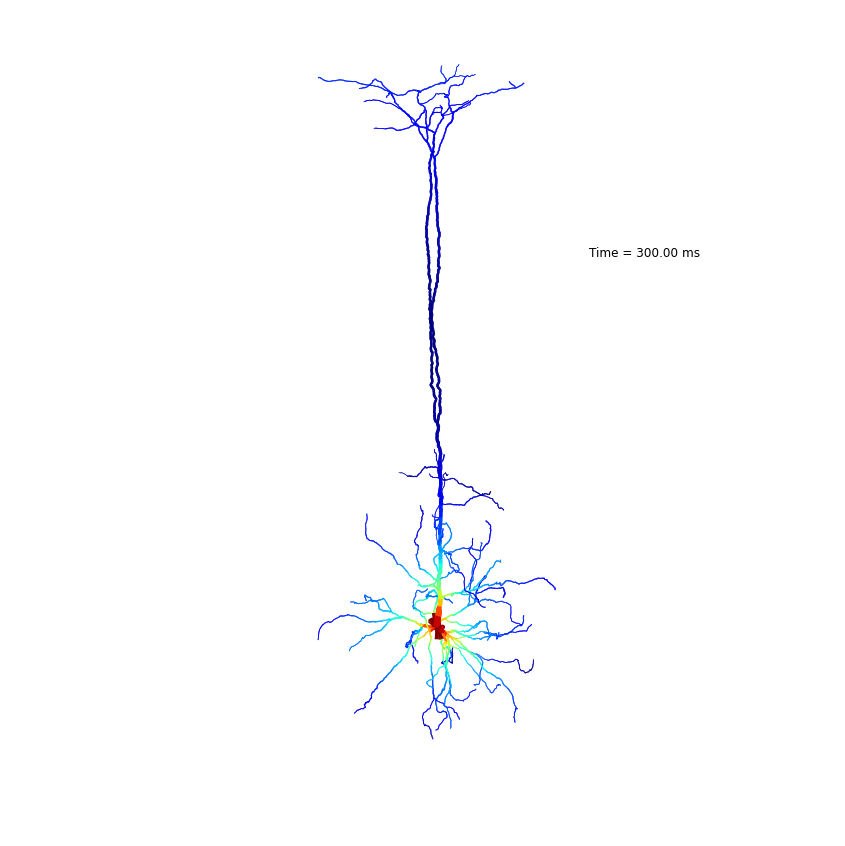
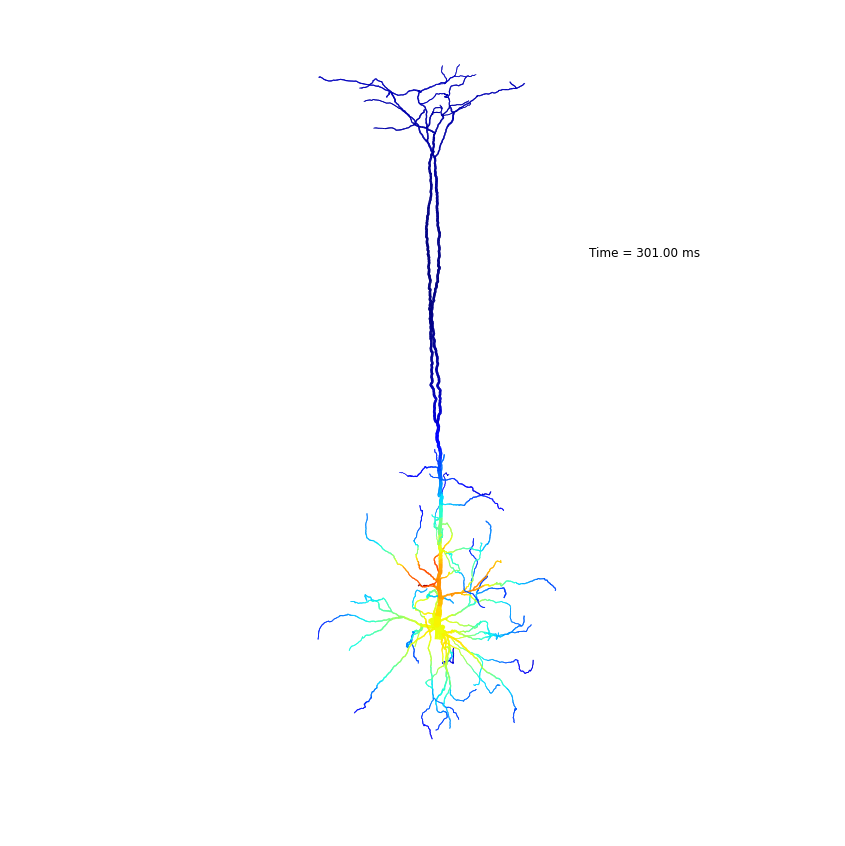
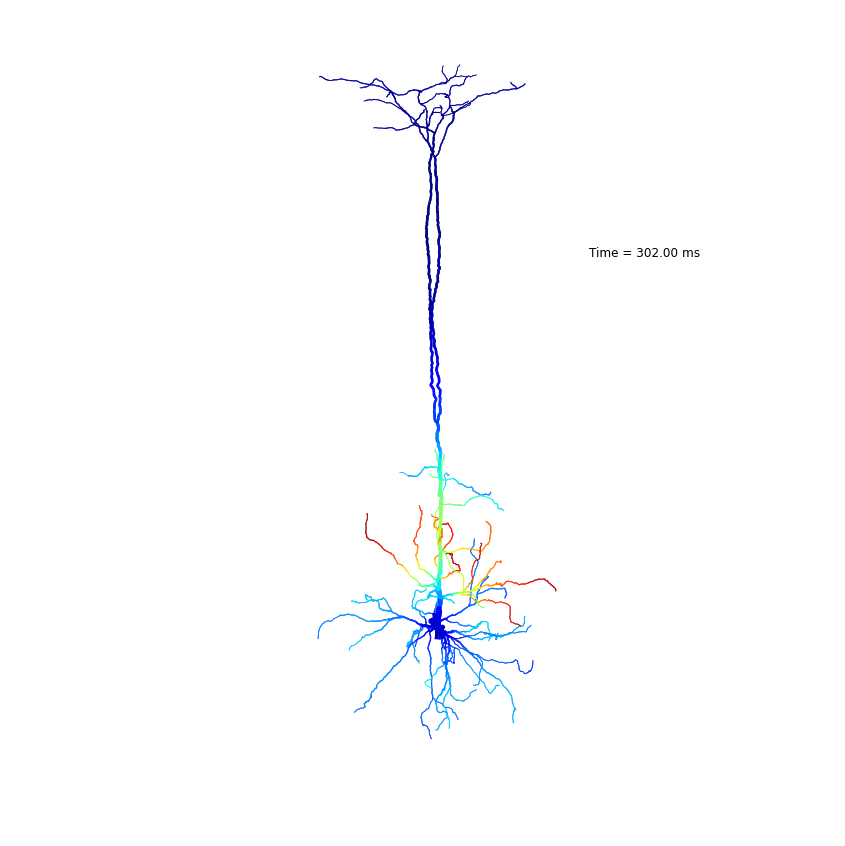
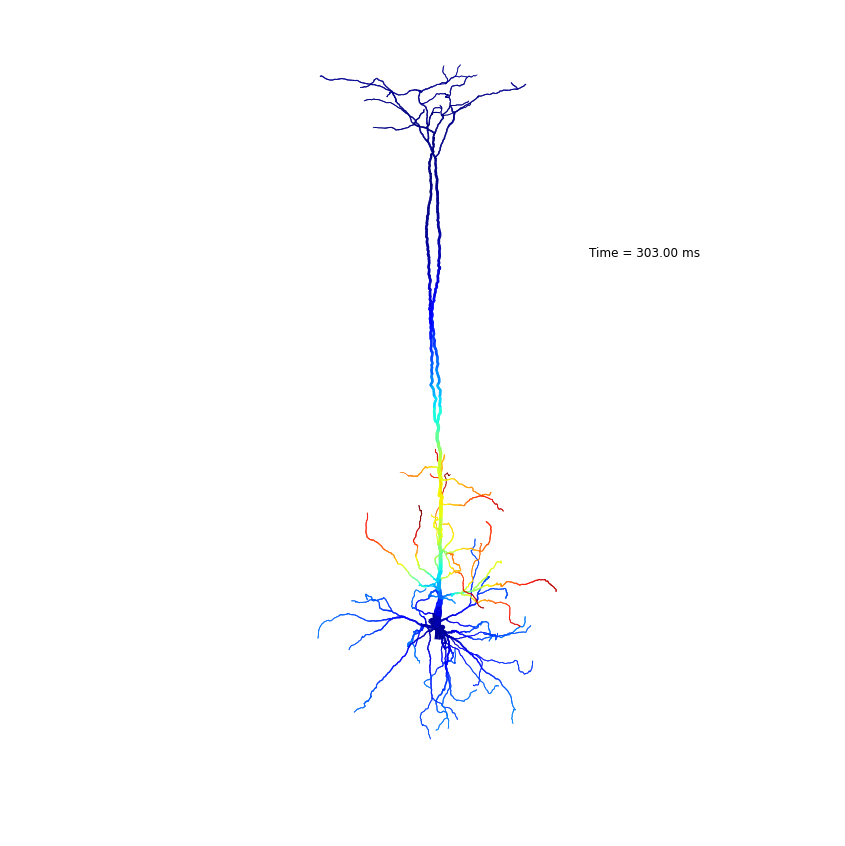
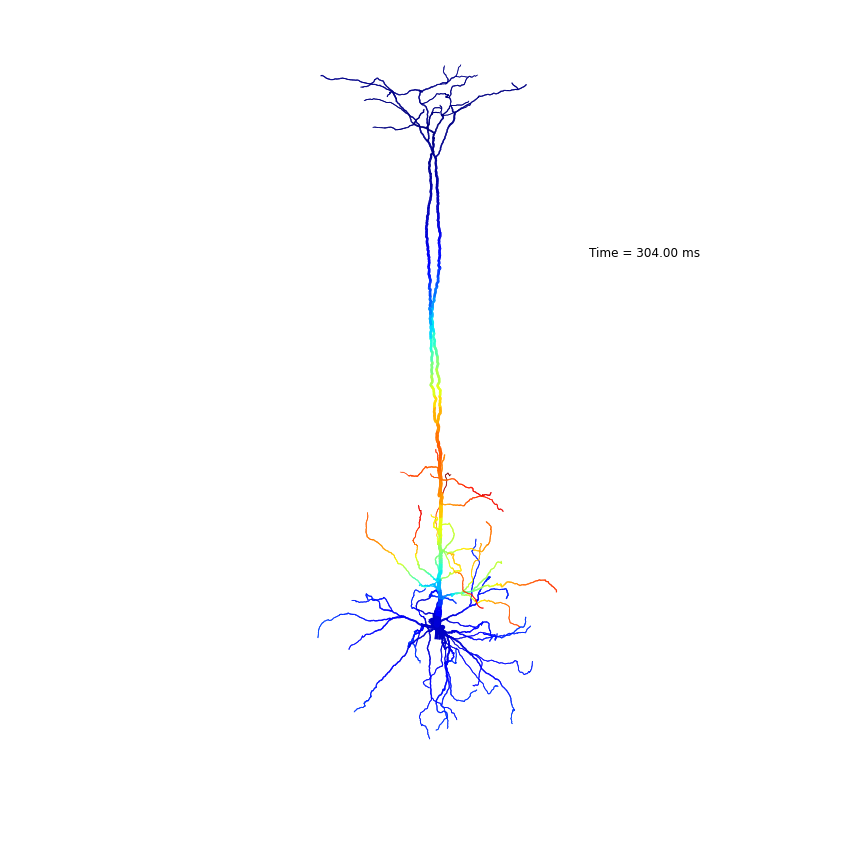
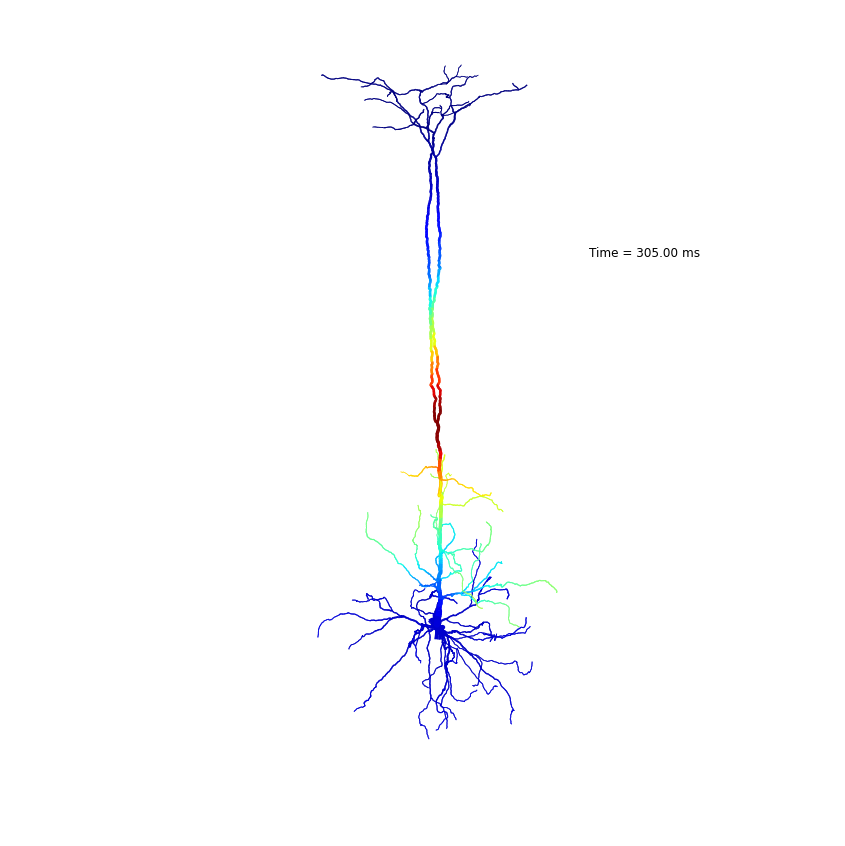
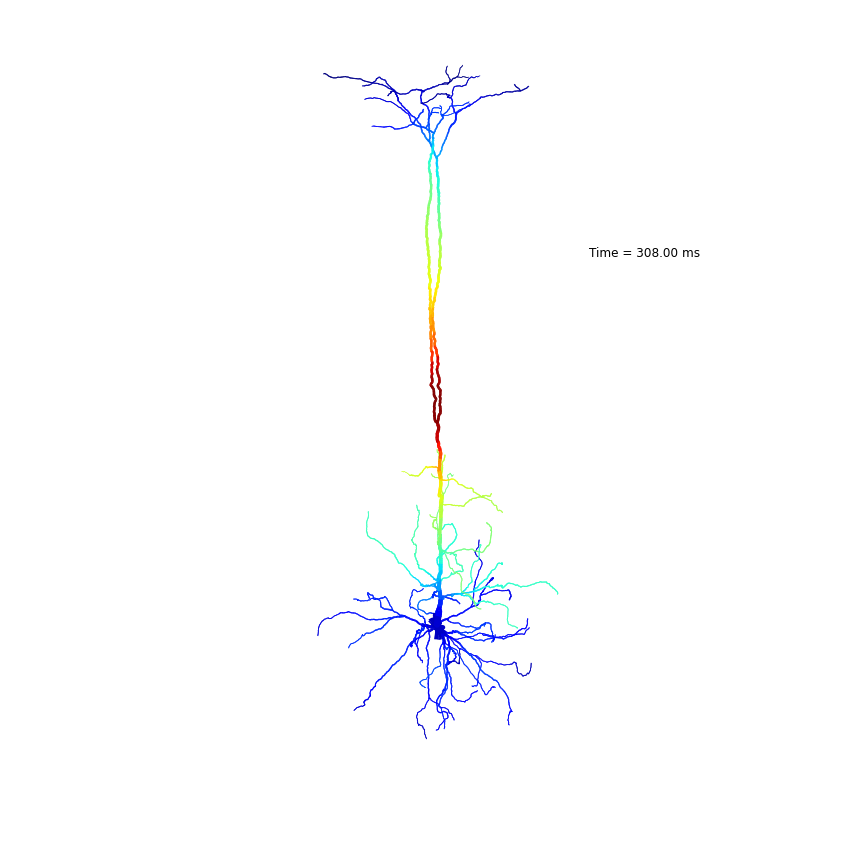
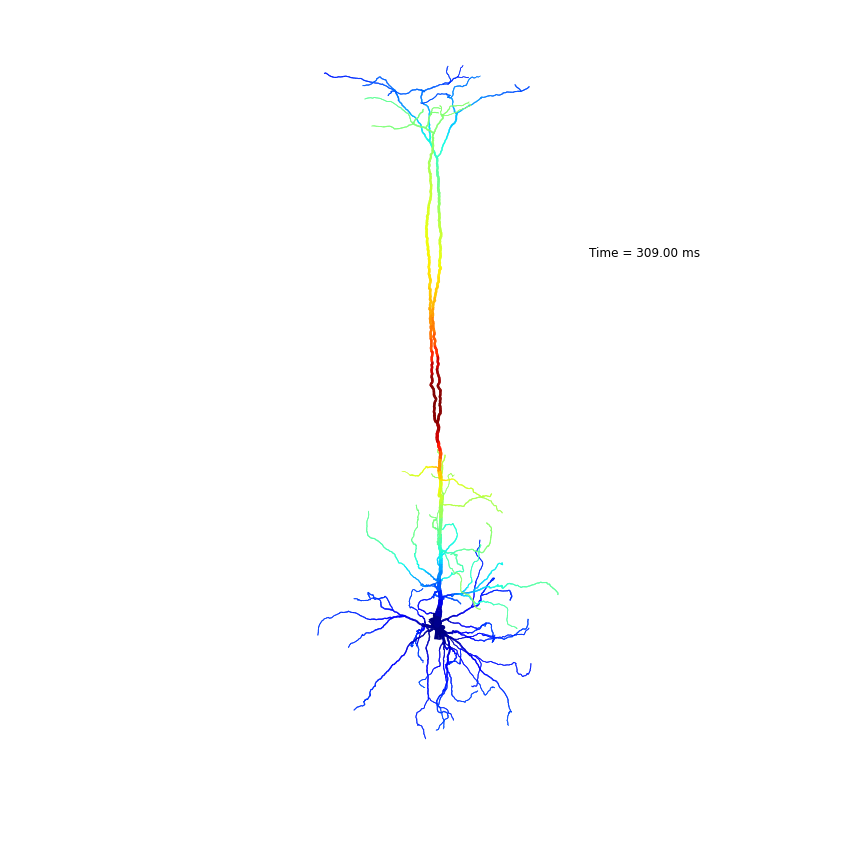
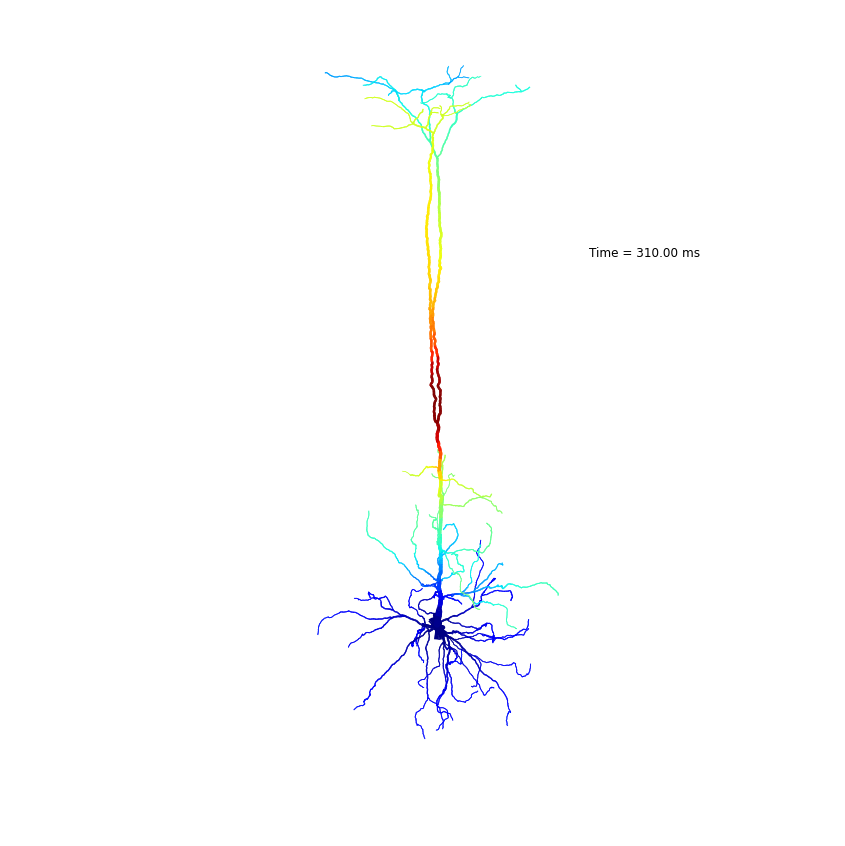
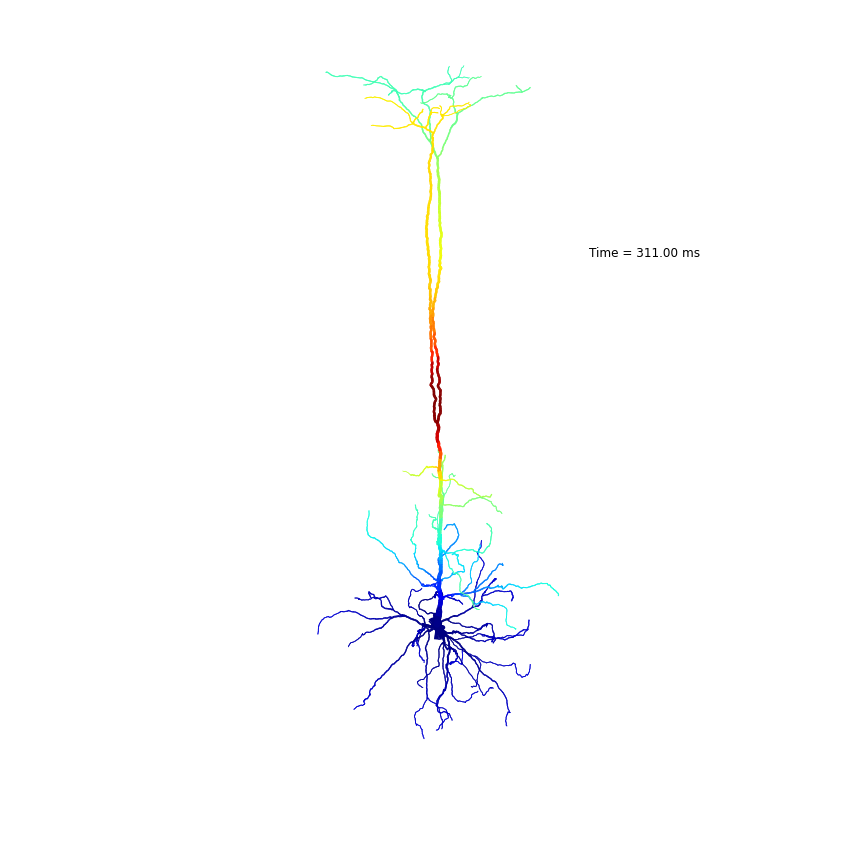
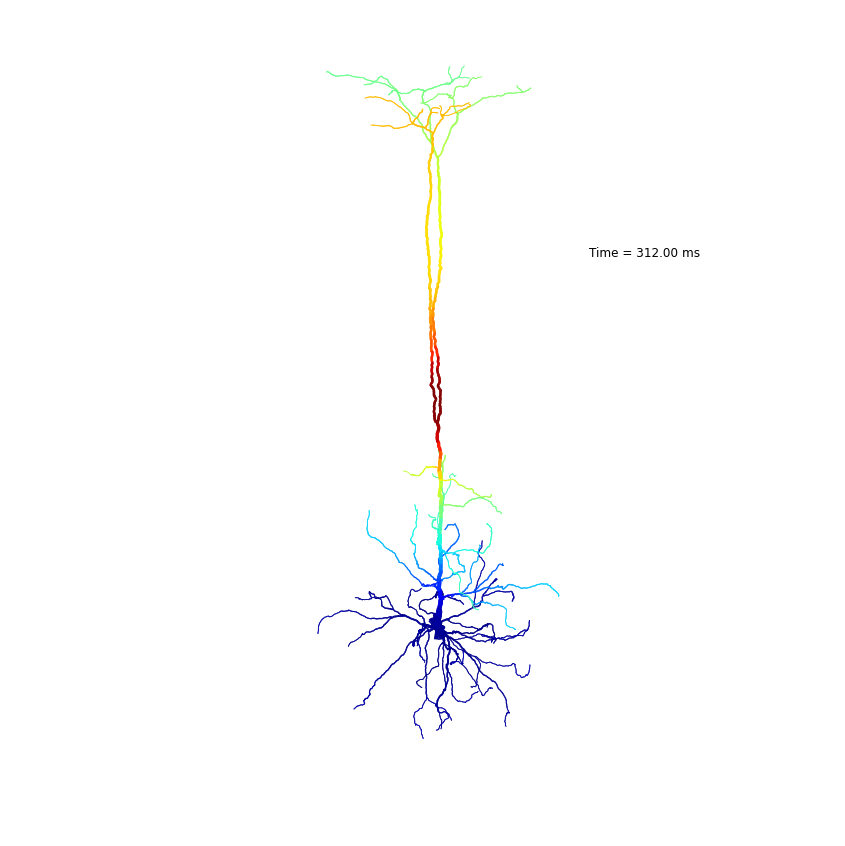
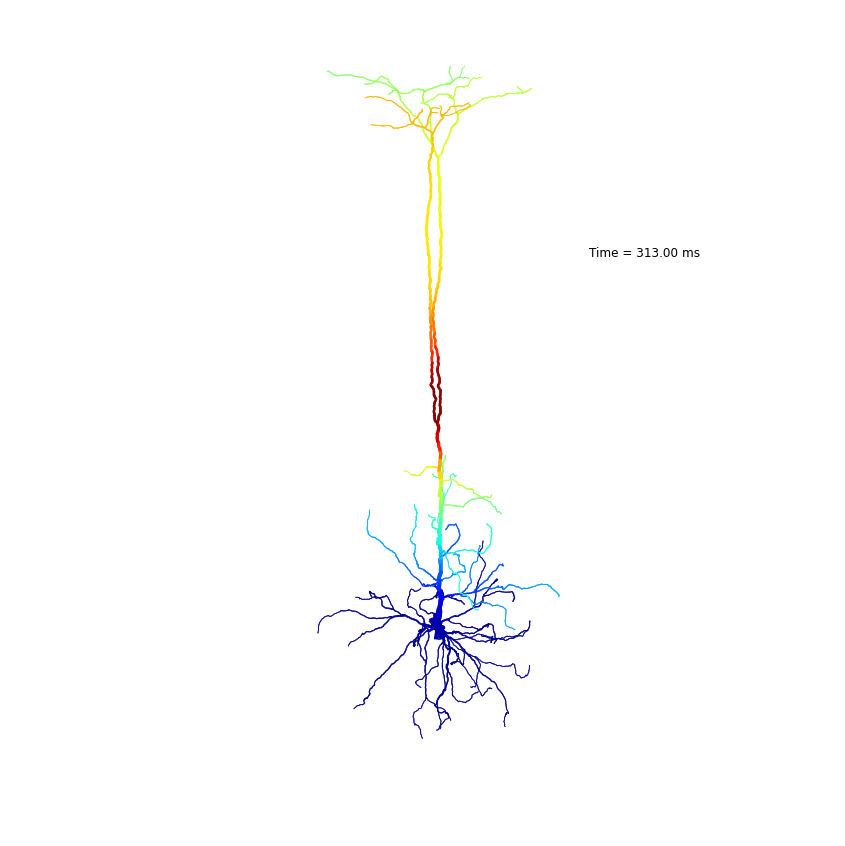
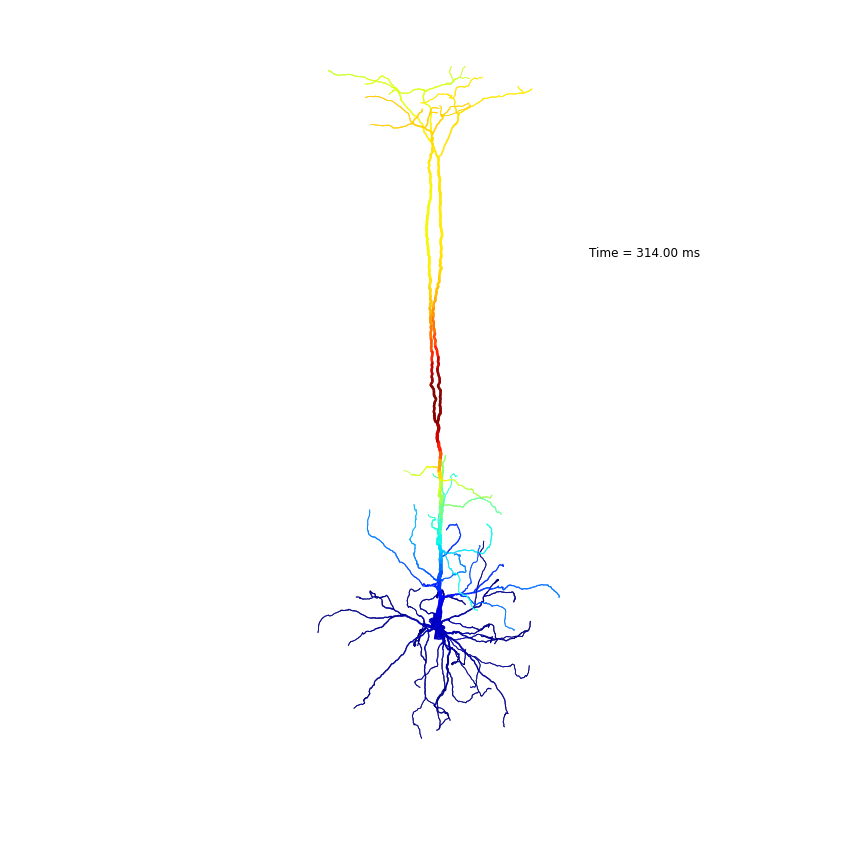
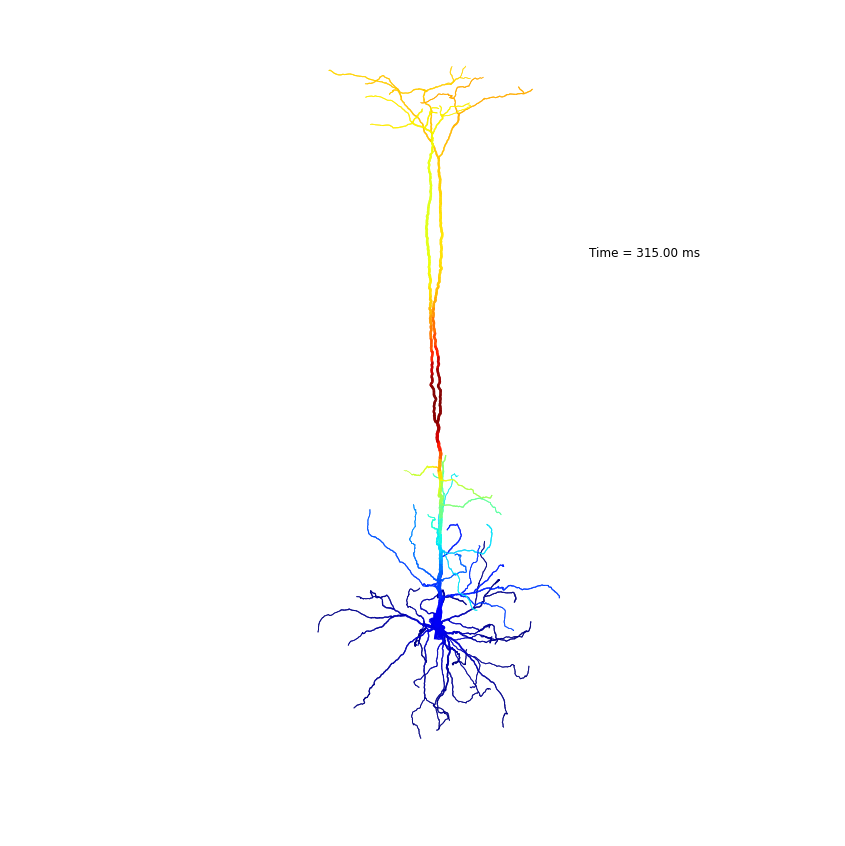
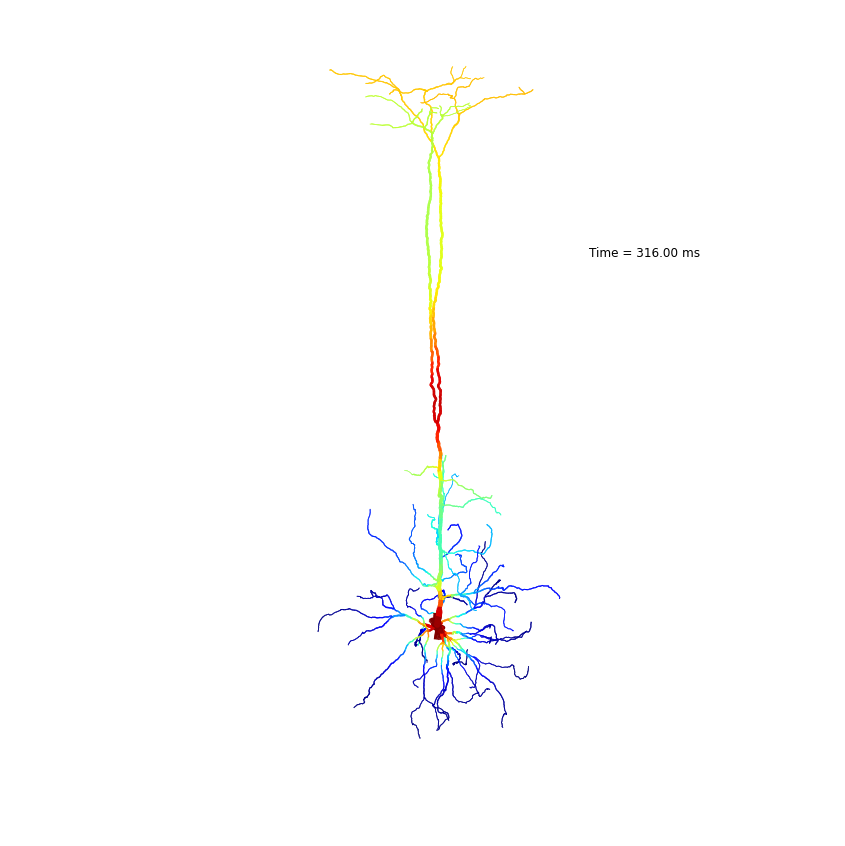
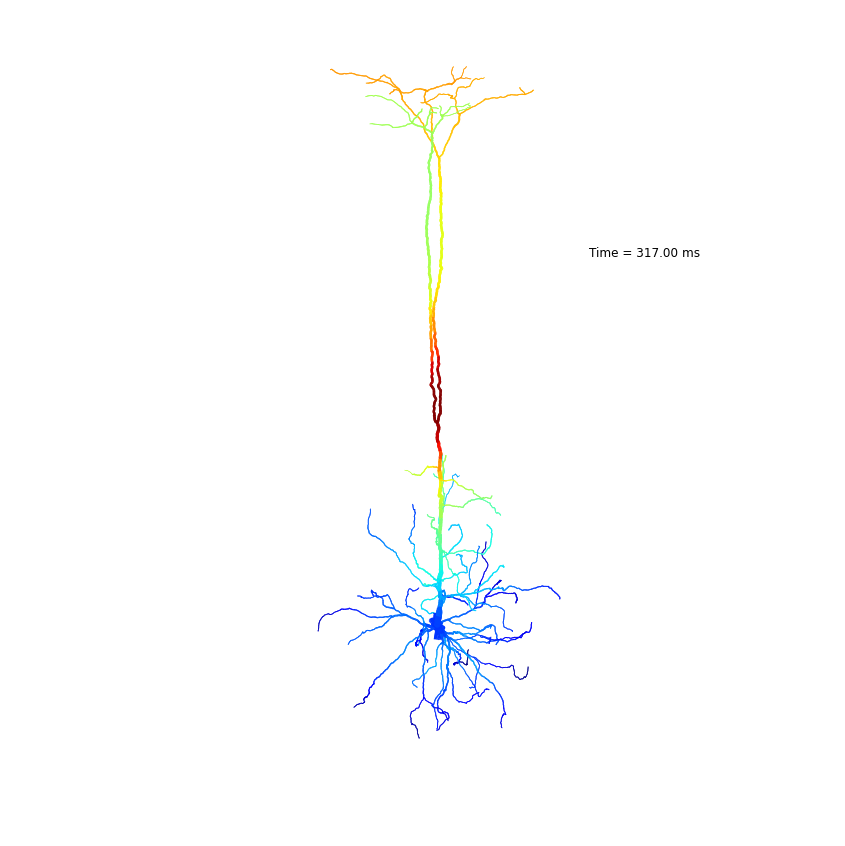
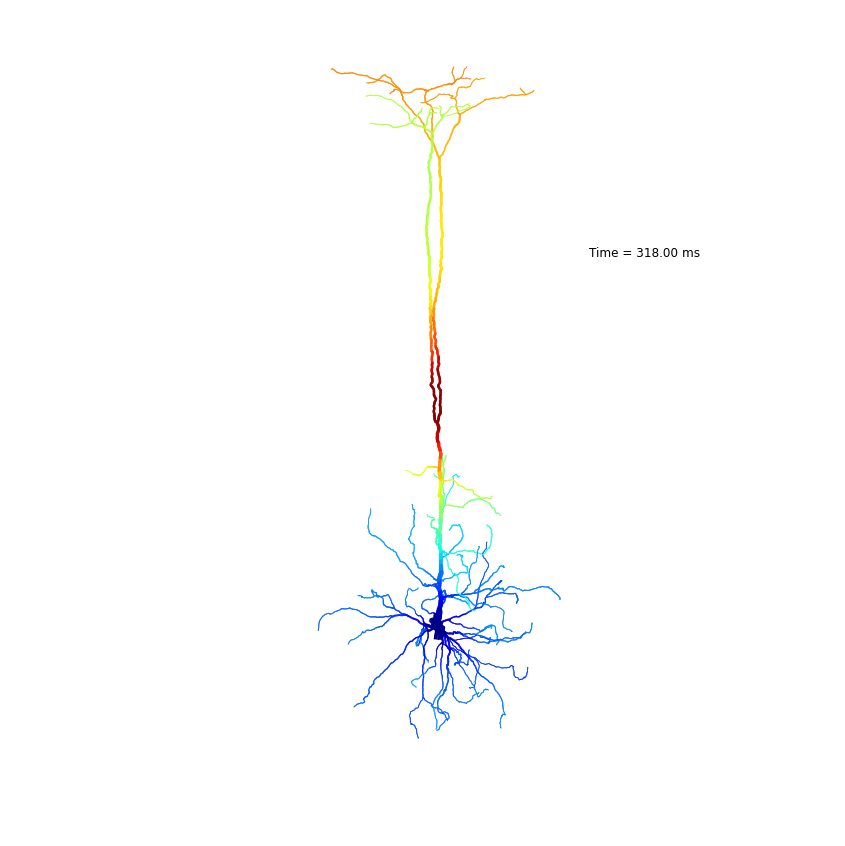
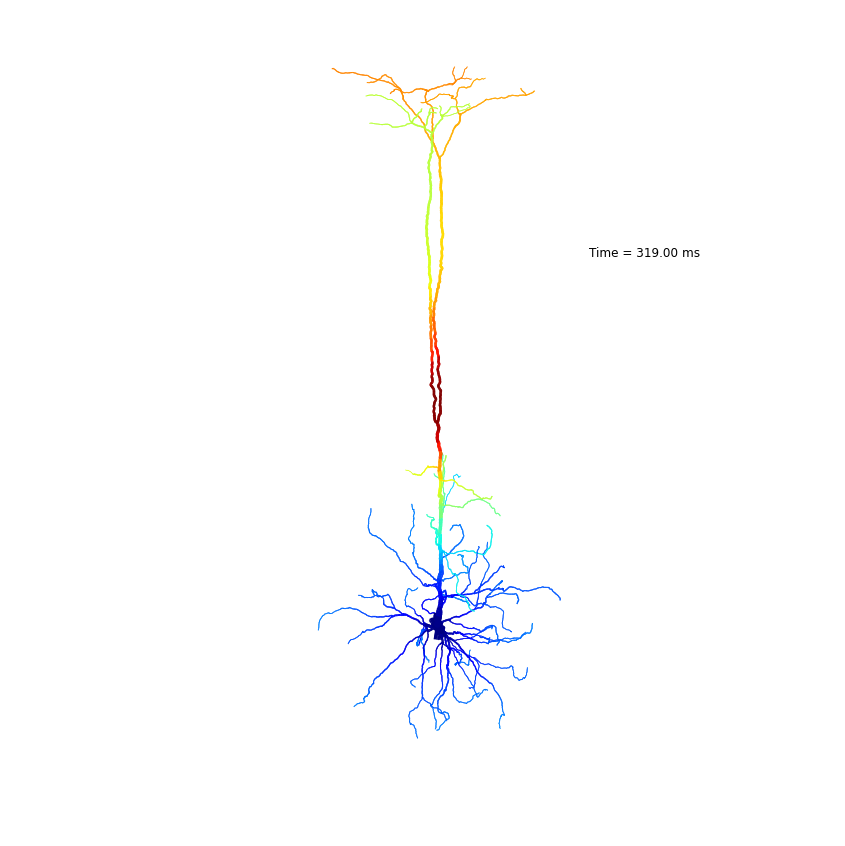
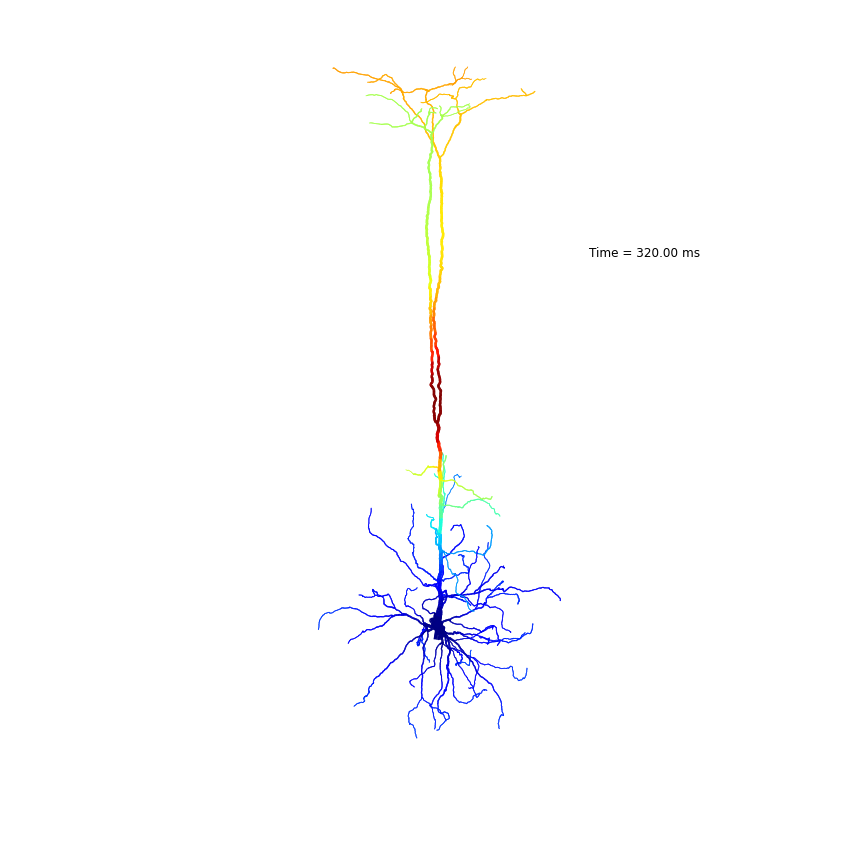
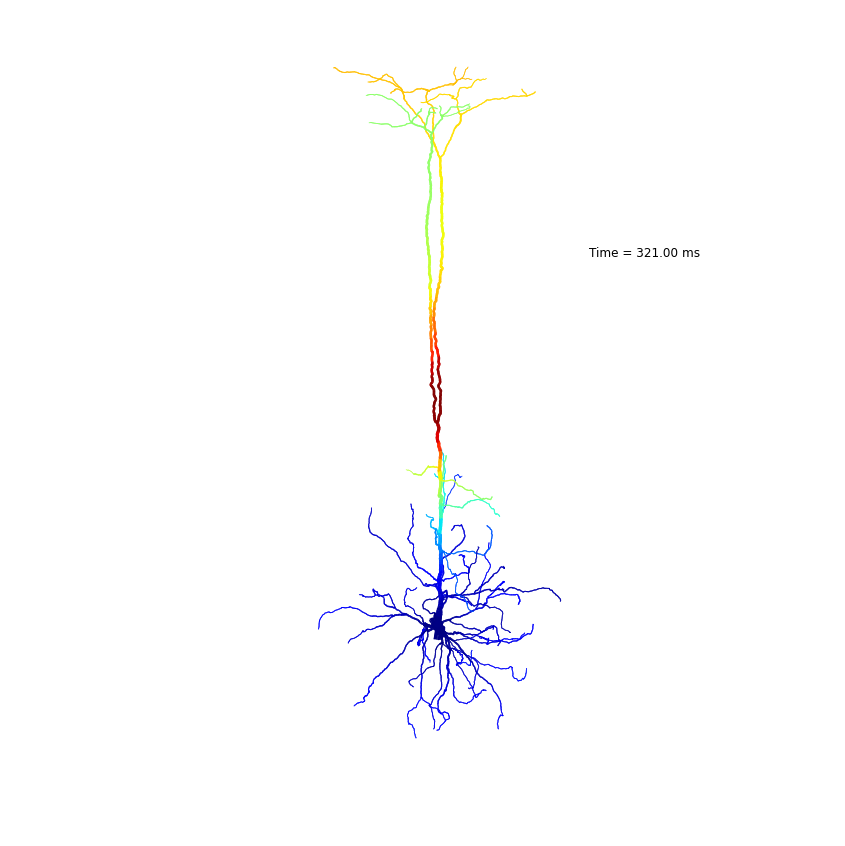
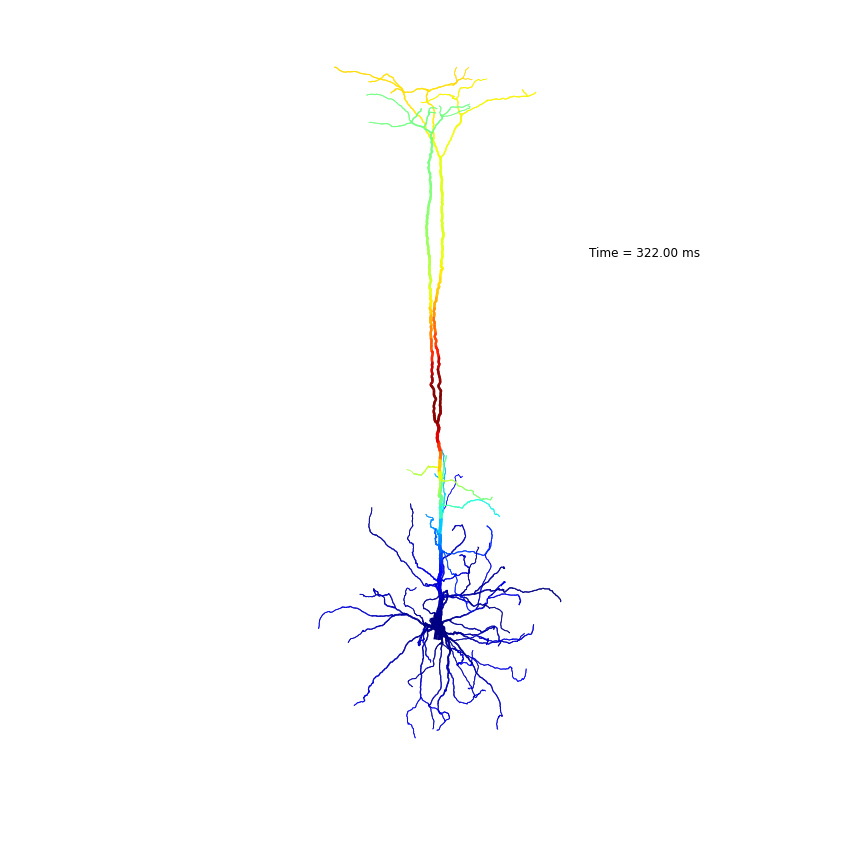
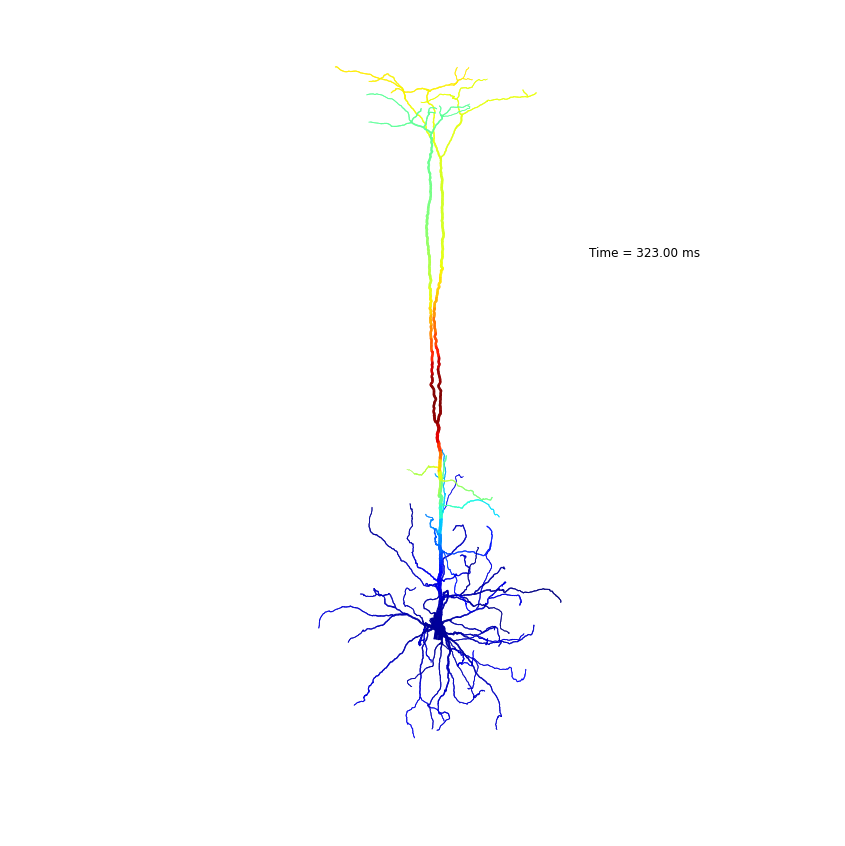
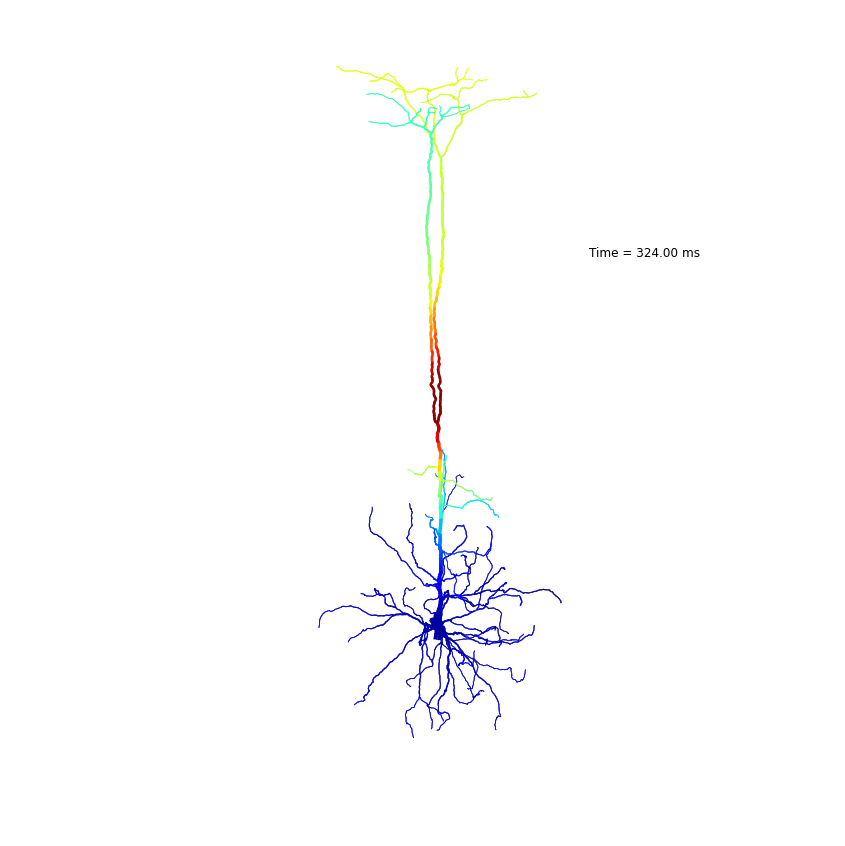
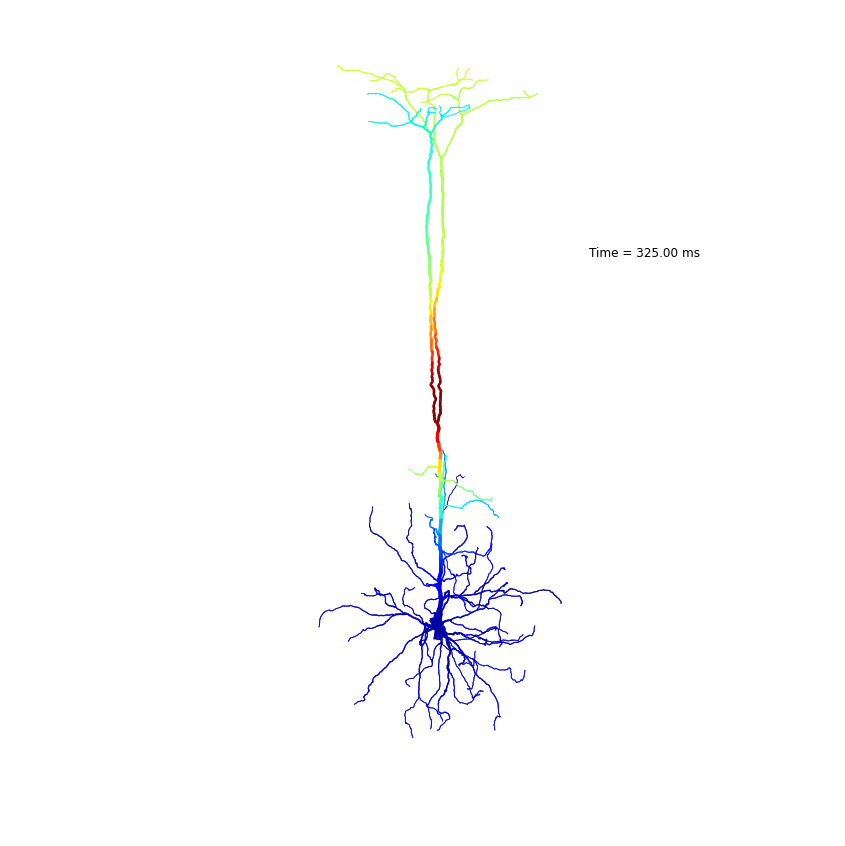
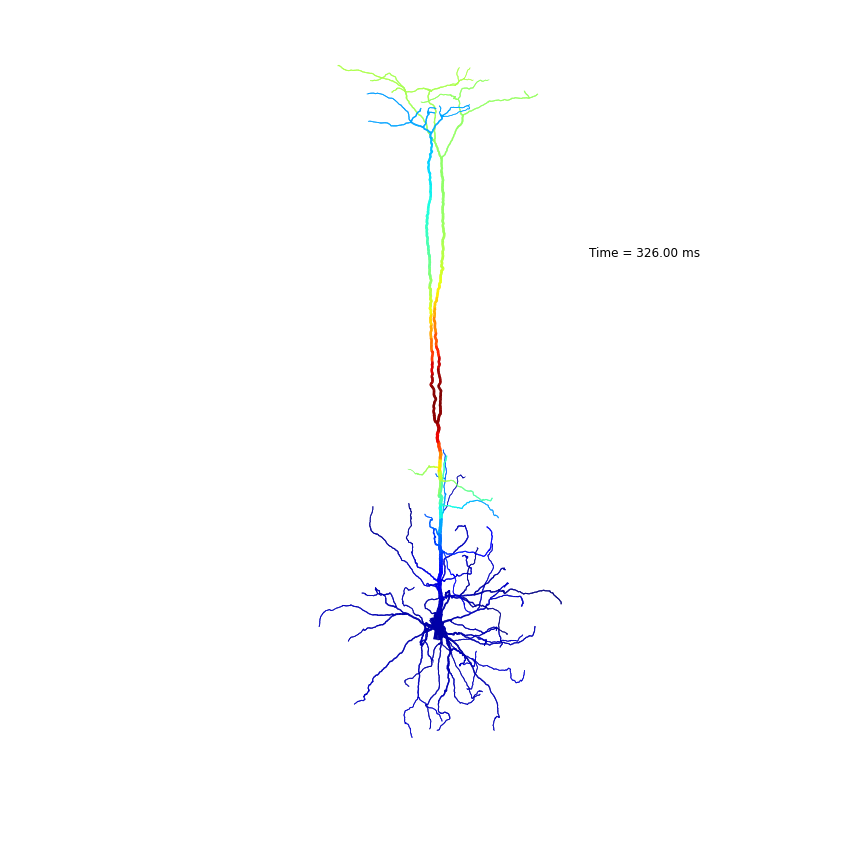
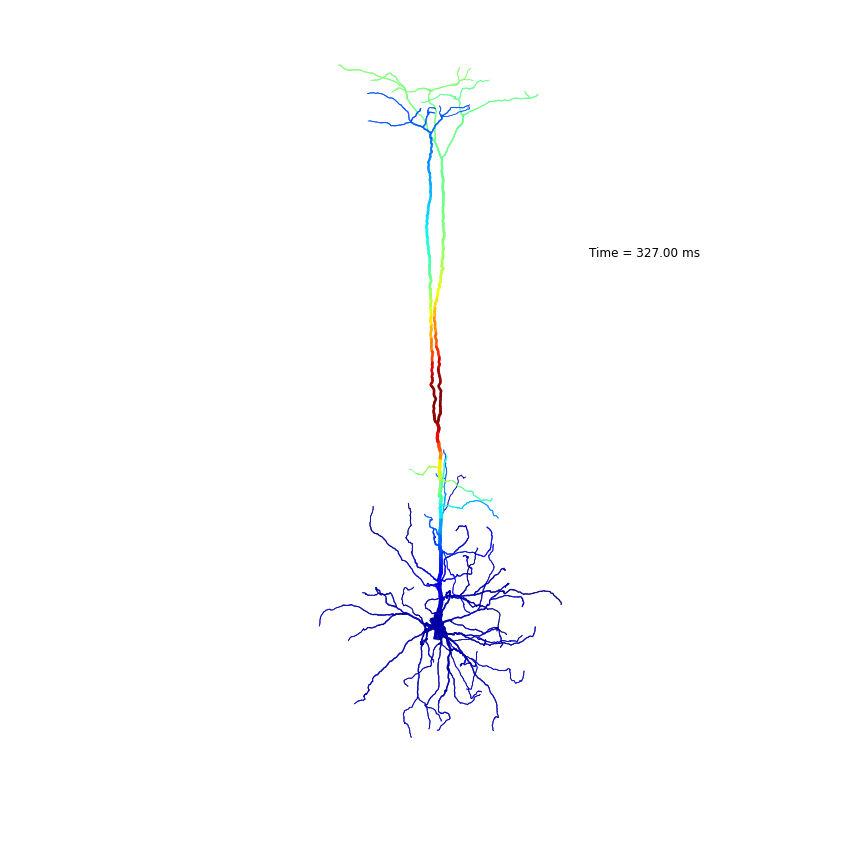
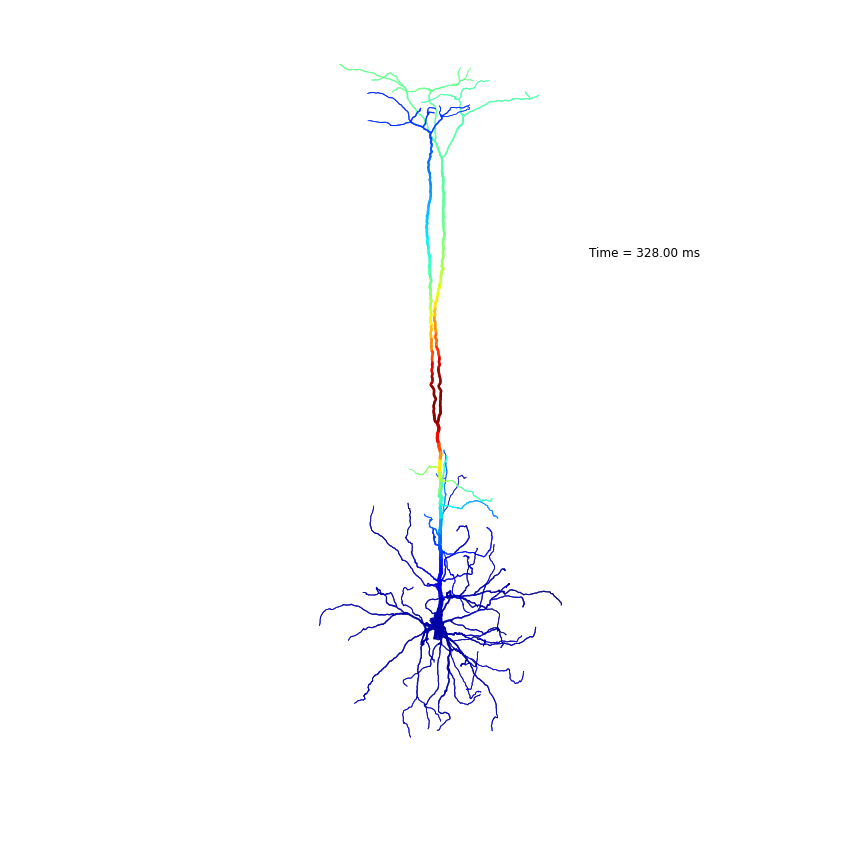
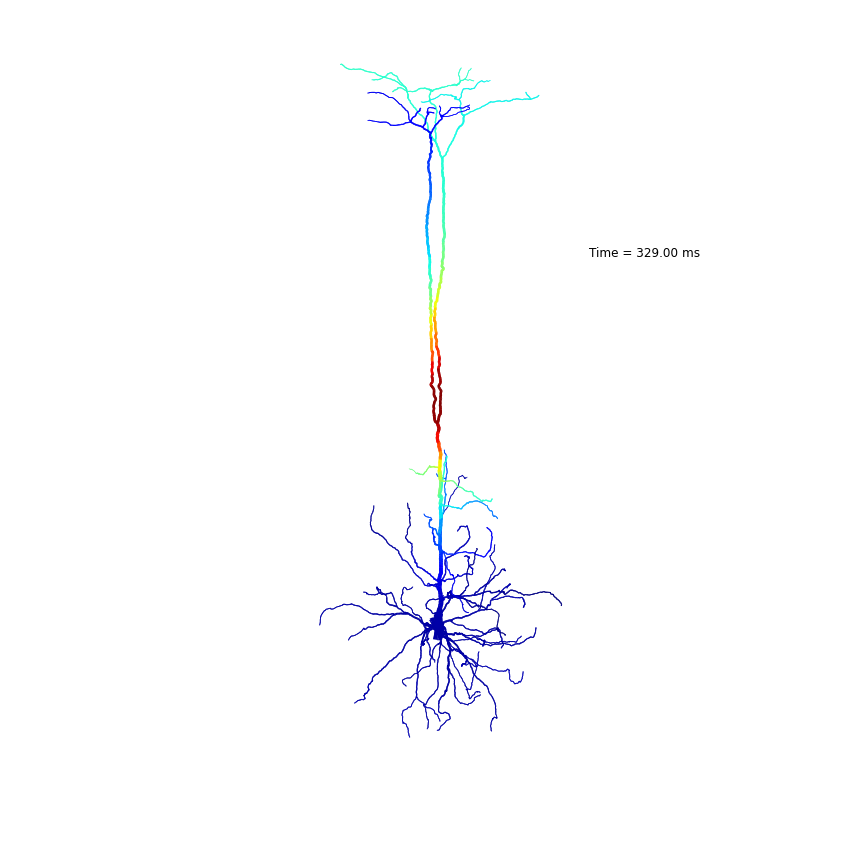
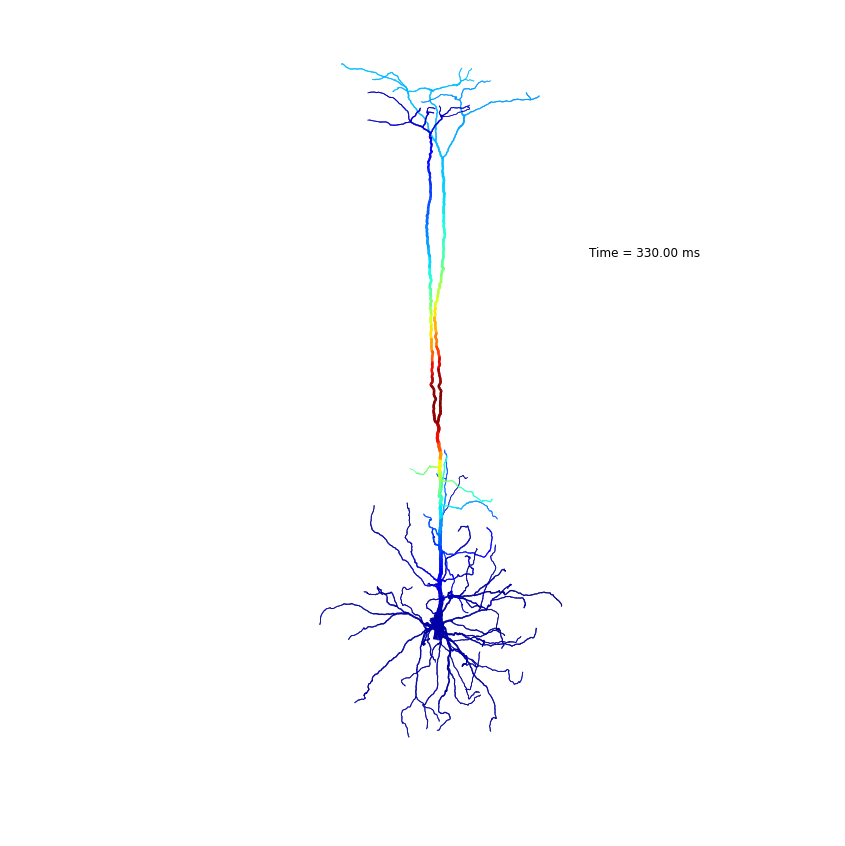
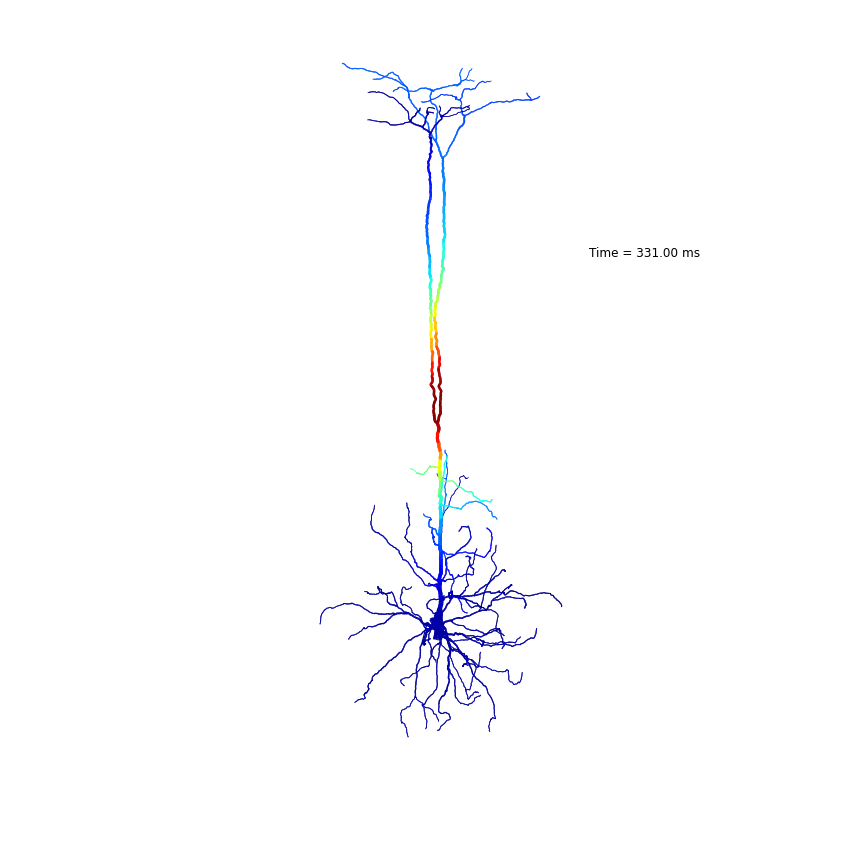
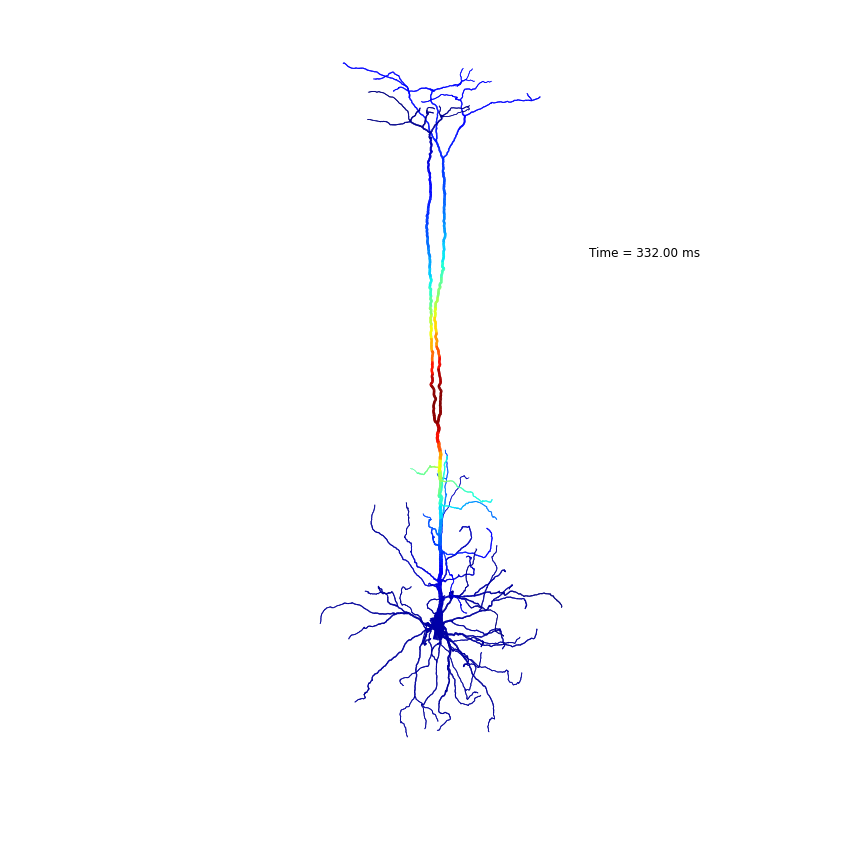
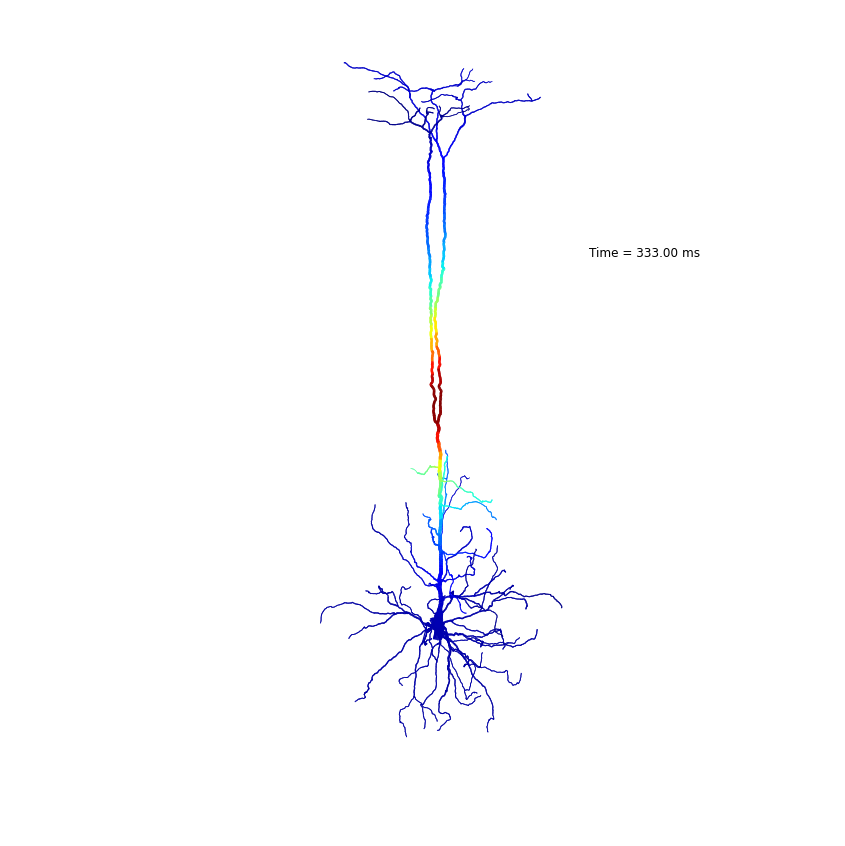
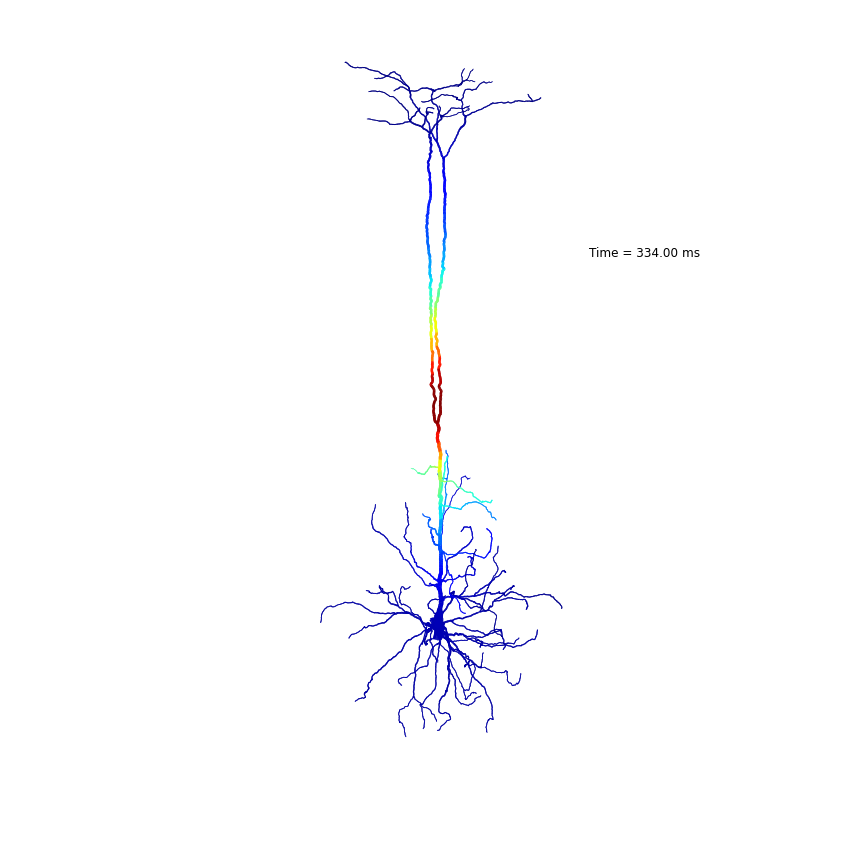
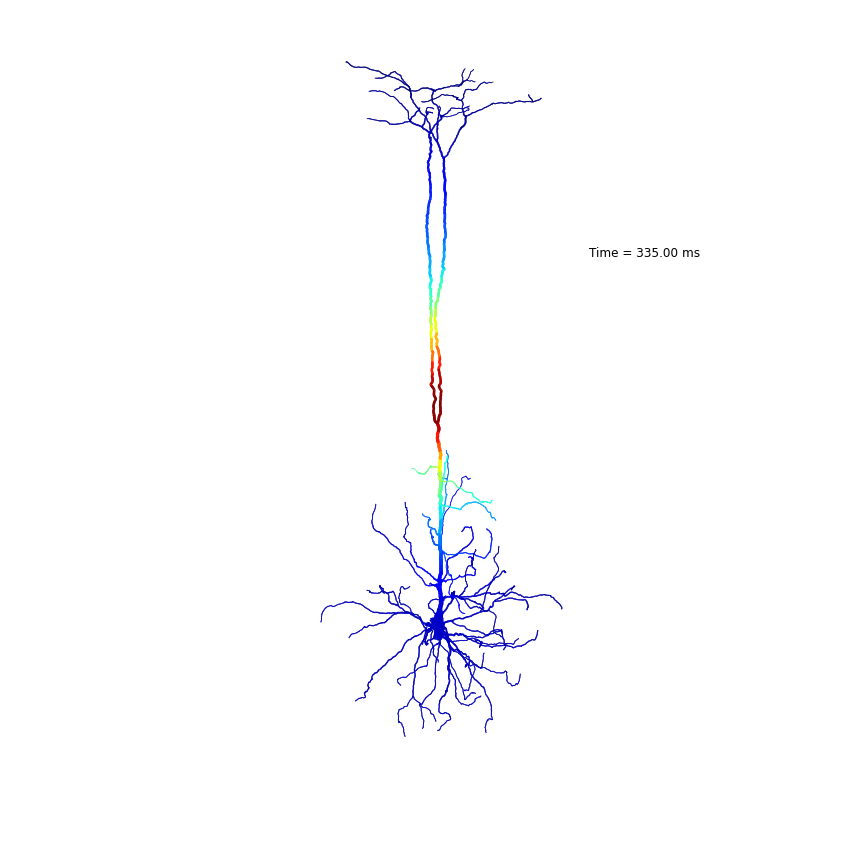
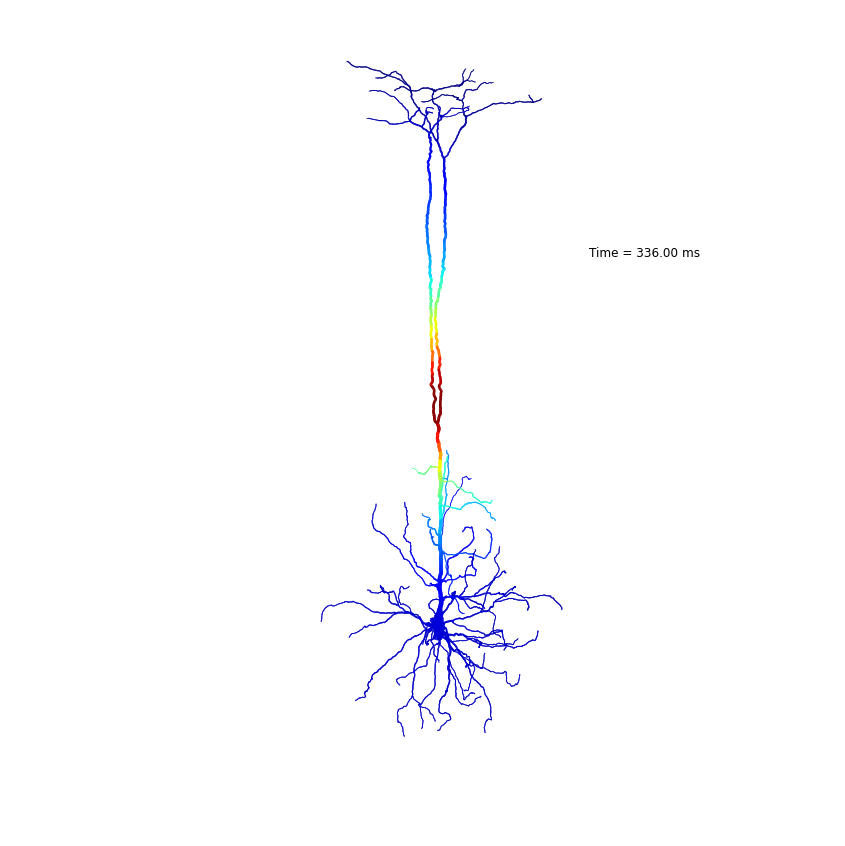
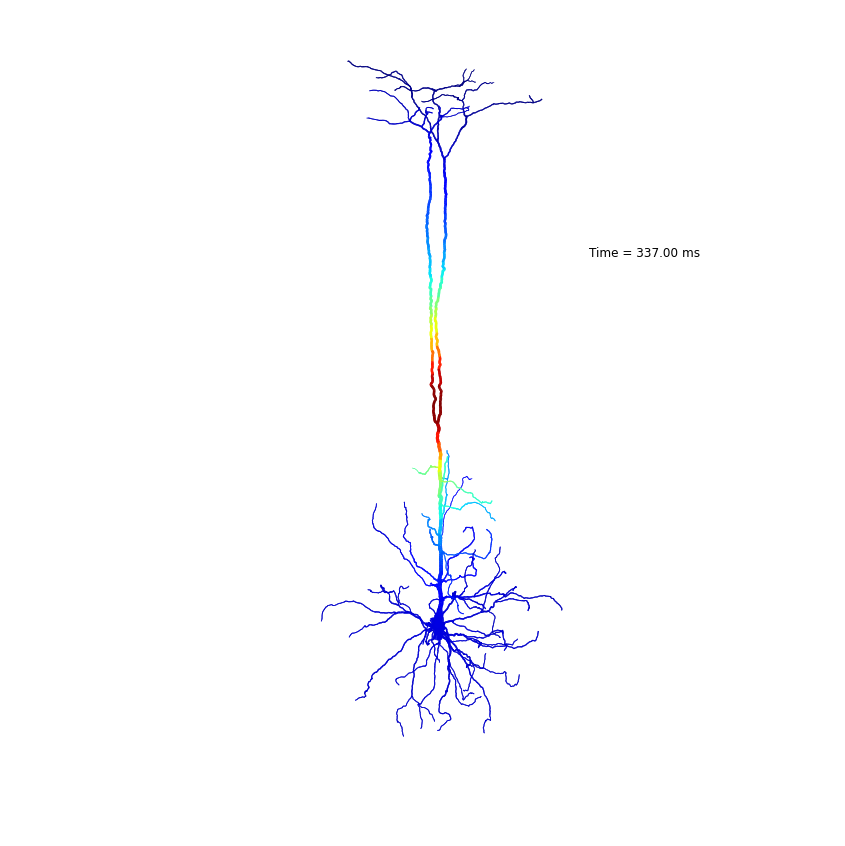
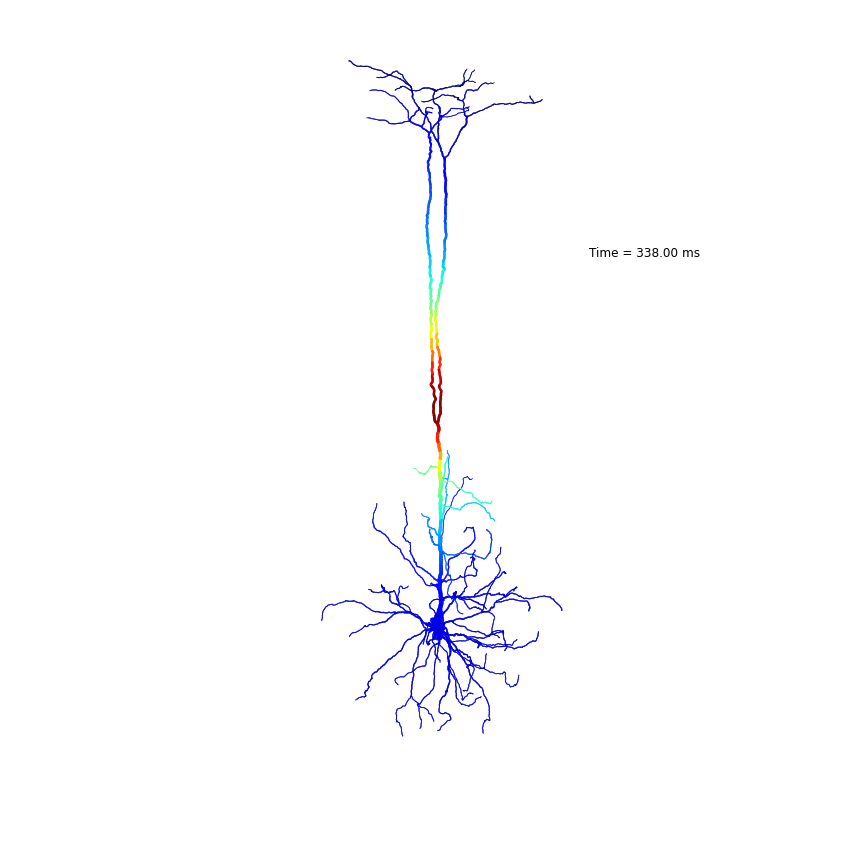
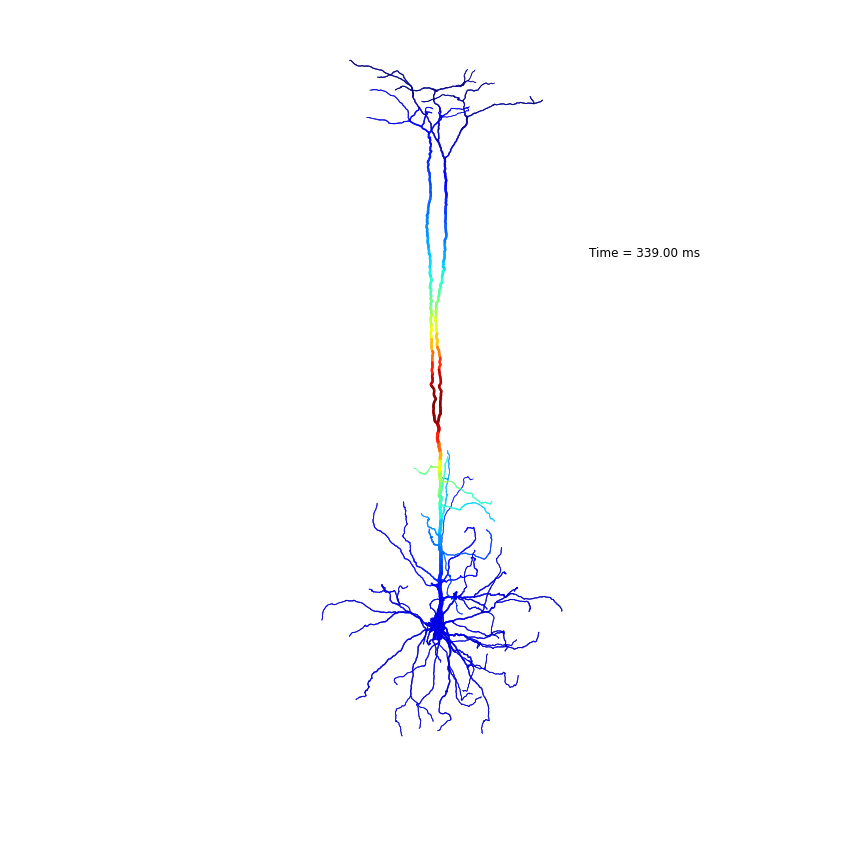
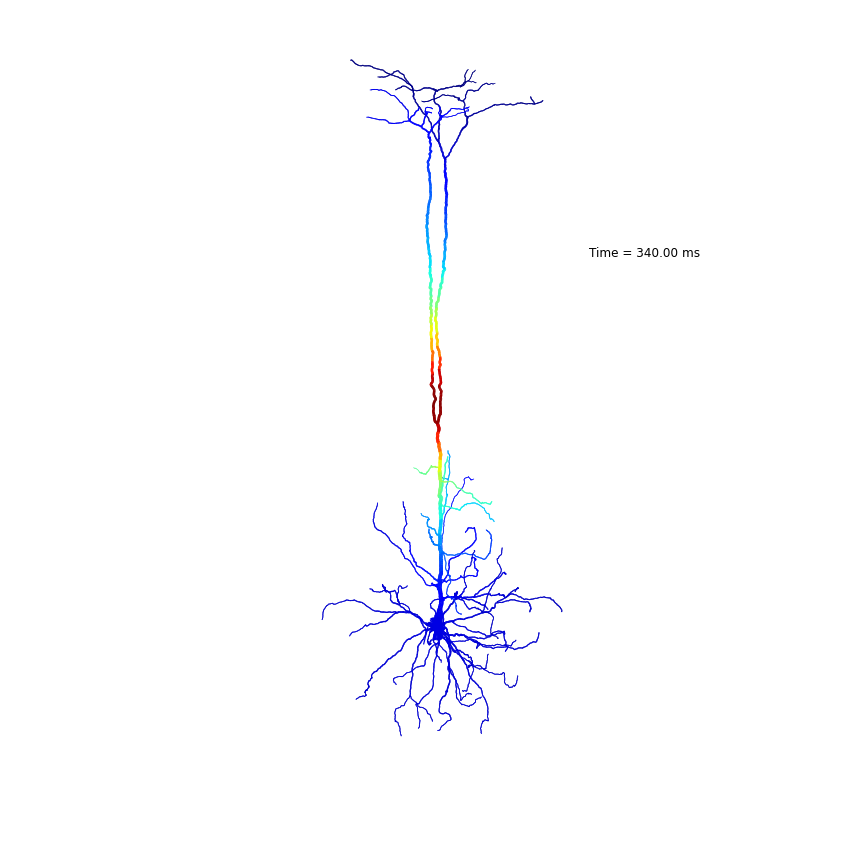
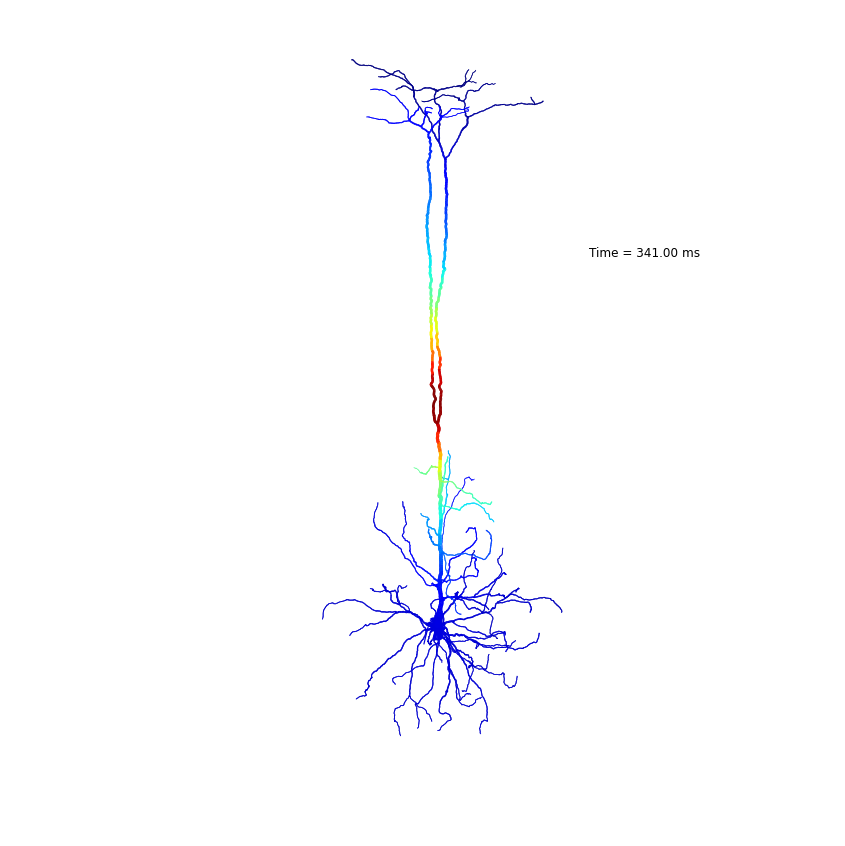
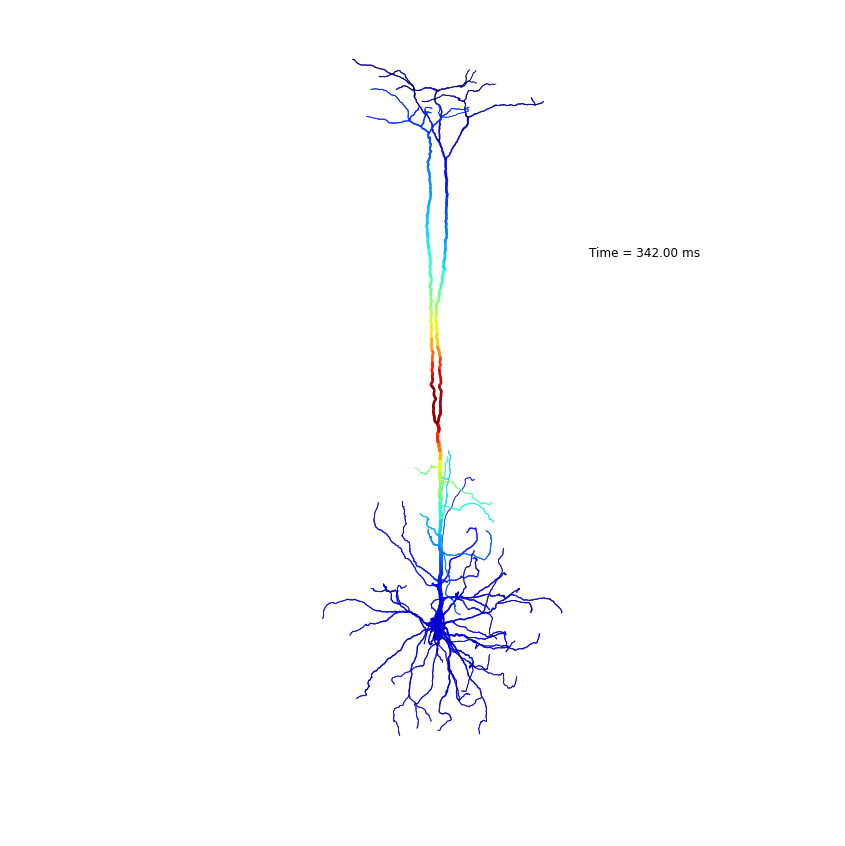
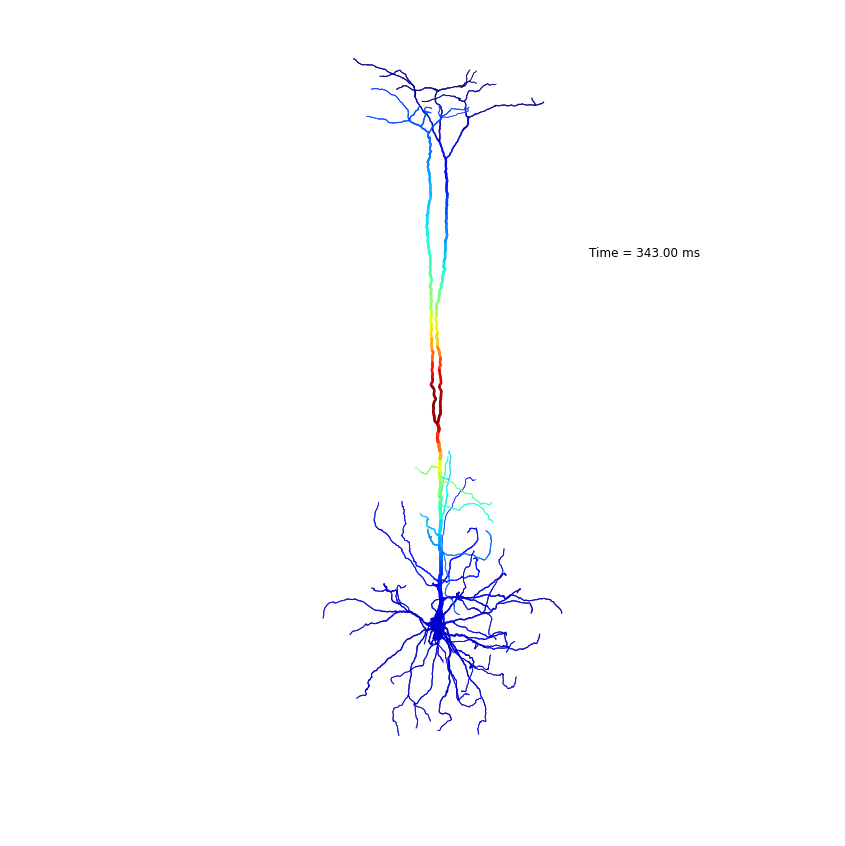
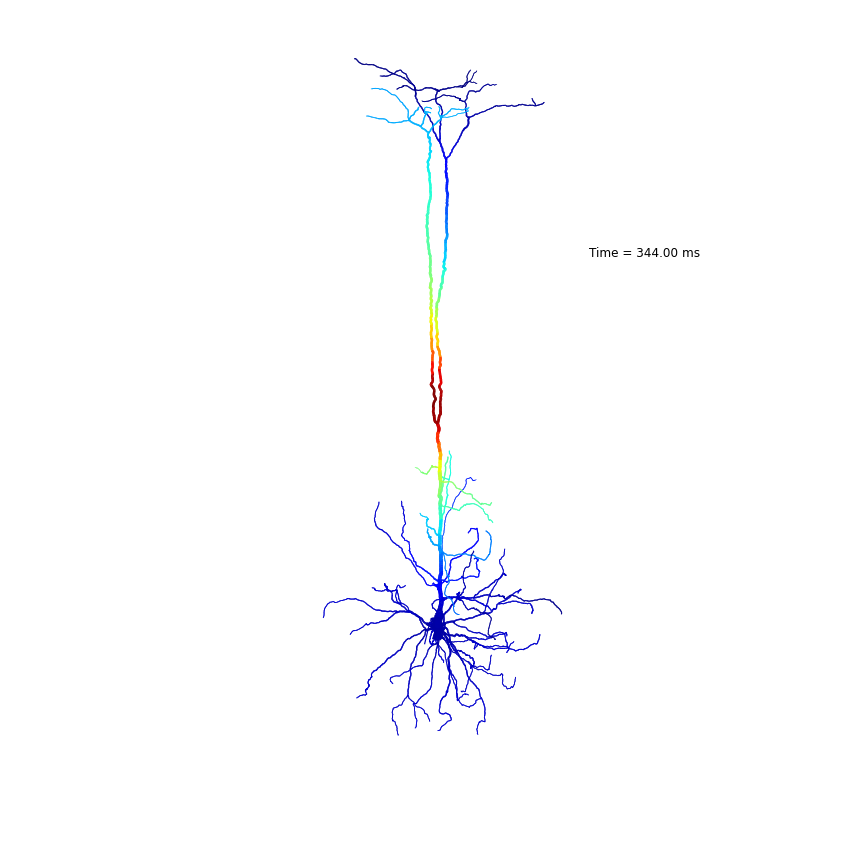
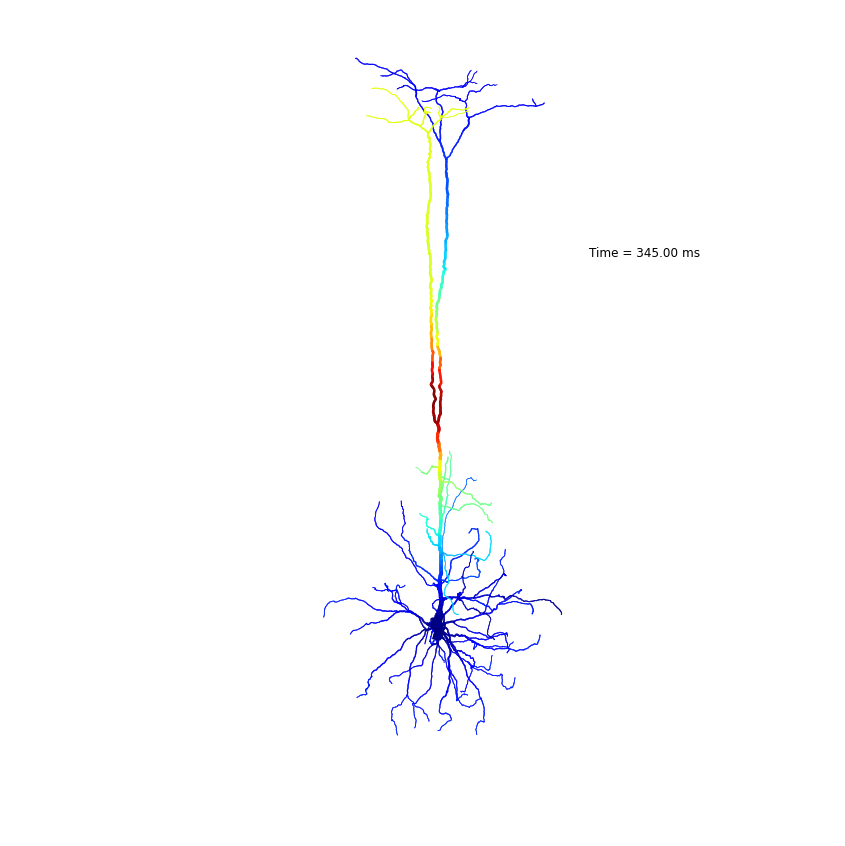
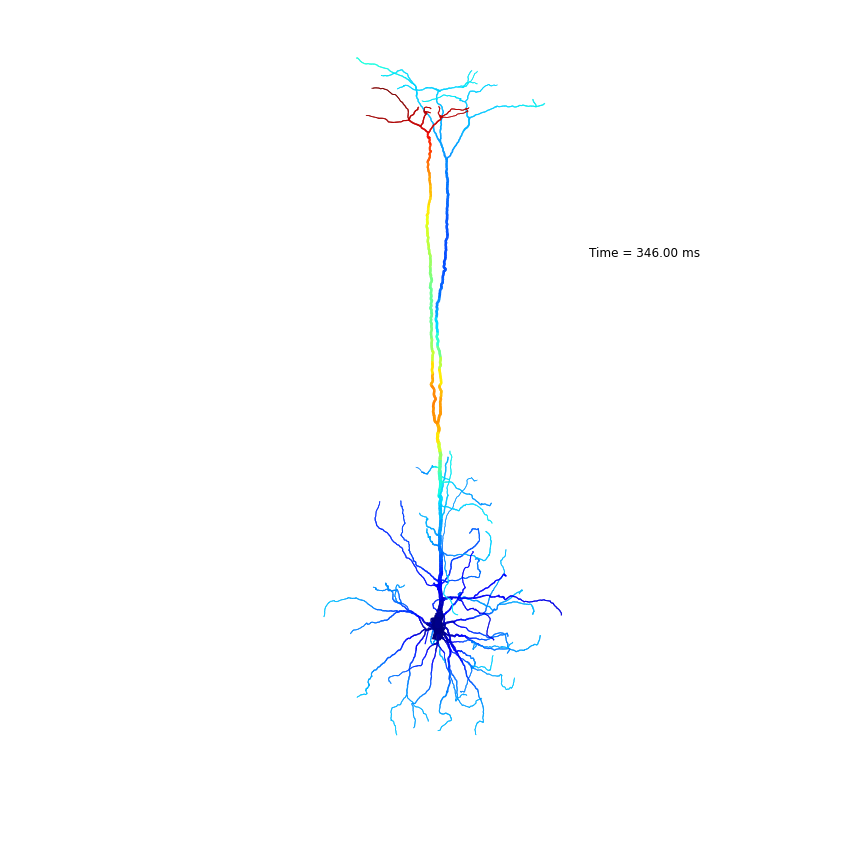
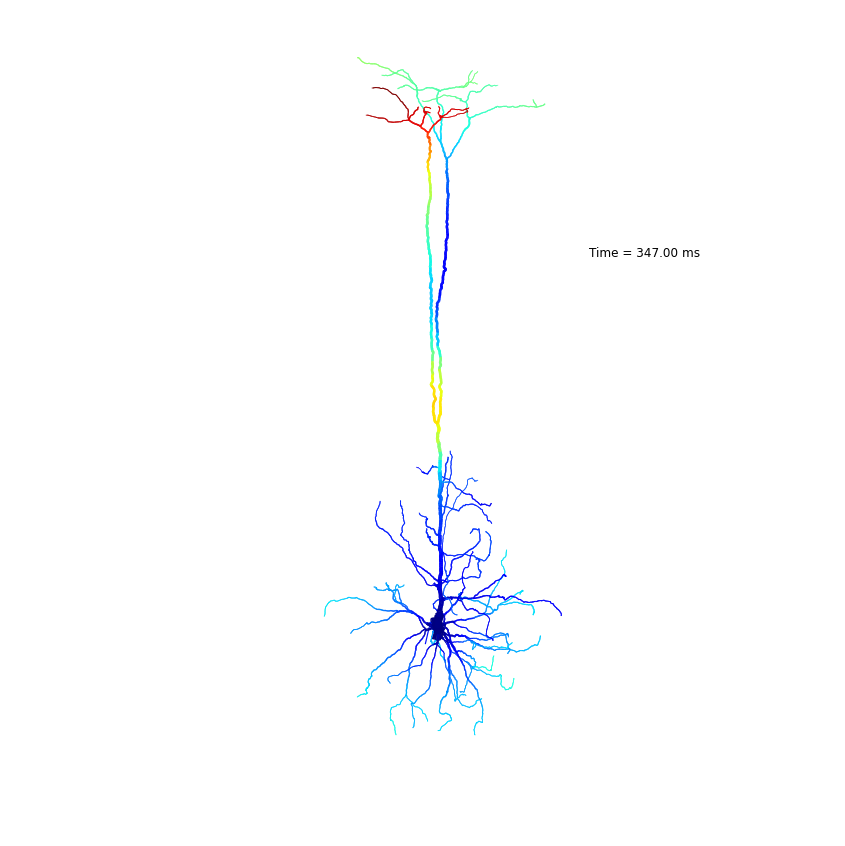
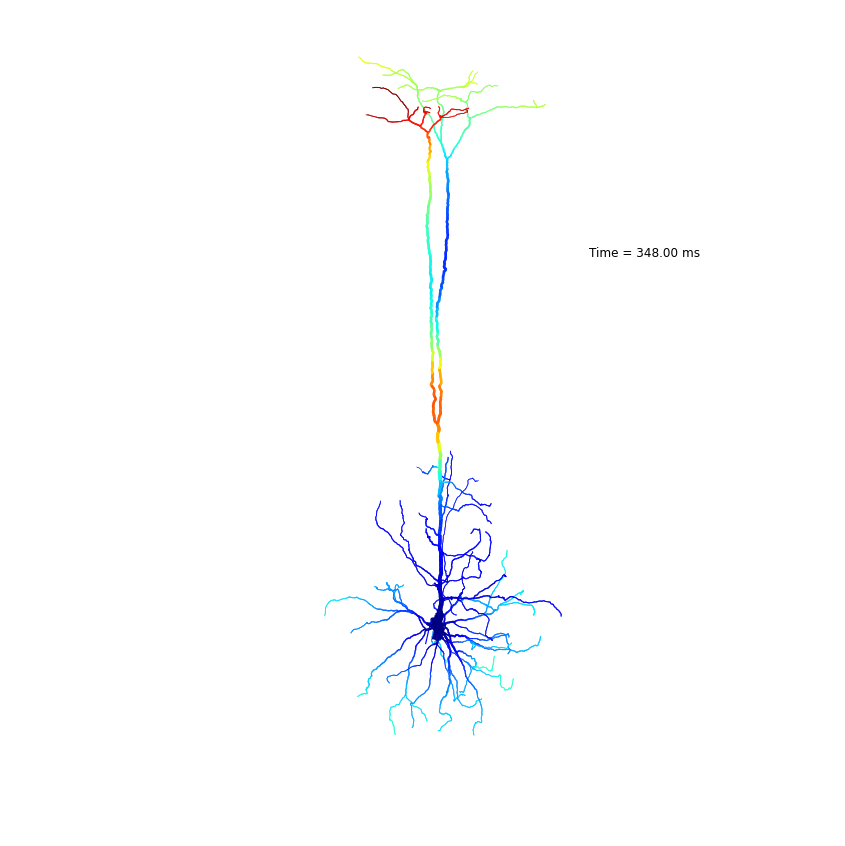
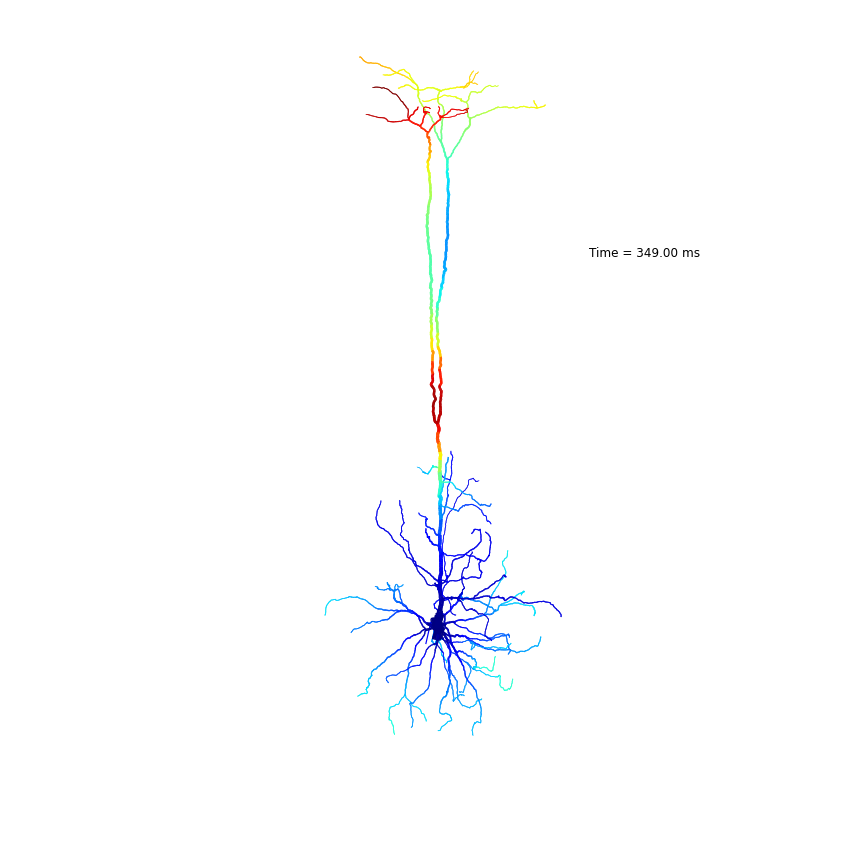
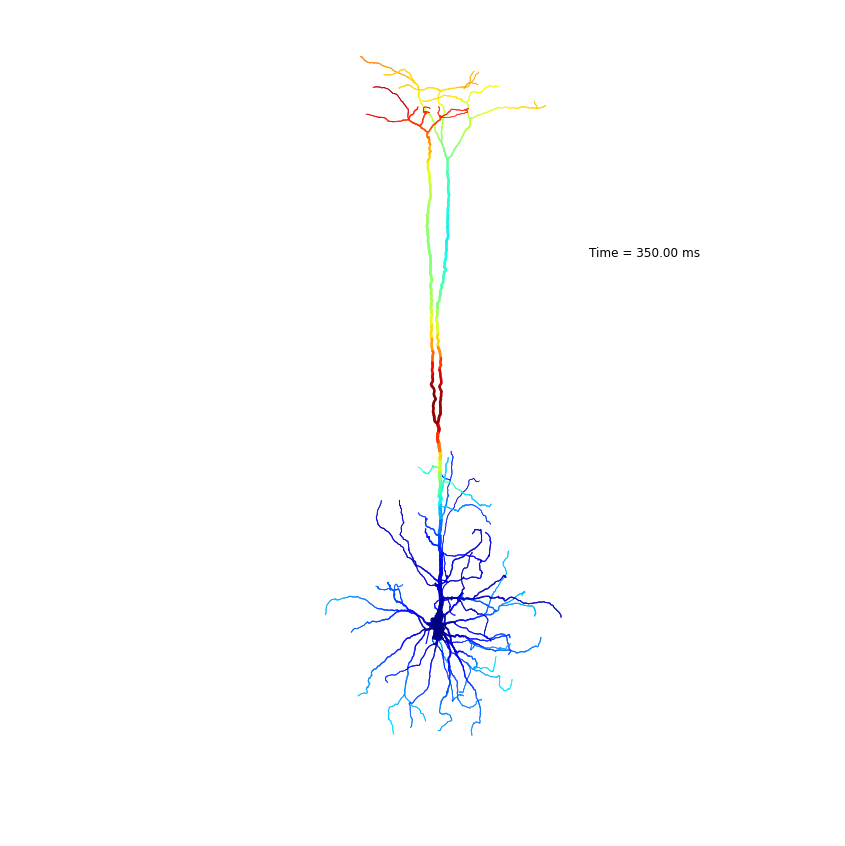

In [30]:
from visualize.cell_morphology_visualizer import CellMorphologyVisualizer

# # Uncomment to re-create the video
# if I.os.path.exists(str(db.basedir/'visualize_morphology_3d')):
#     I.shutil.rmtree(str(db.basedir/'visualize_morphology_3d'))
output_folder = str(db.basedir/'visualize_morphology_3d')

cmv = CellMorphologyVisualizer(
    cell, 
    t_start=295, t_stop=350, t_step=1)
cmv.animation(
    output_folder, 
    client=I.get_client(), 
    color="voltage",
    show_legend=True)

### Running all stimulus protocols

In the previous section, we ran an example $bAP$ stimulus, and a $BAC$ stimulus. This resulted in a single AP, and a triplet respectively. In order to verify if the biophysical properties of the cell match empirically observed responses, we also need to run $3$ step currents and measure the response.

For this, we have a Simulator that has these step currents set up:

In [27]:
s = get_Simulator(fixed_params, step=True)
s.setup.cell_param_generator = get_L5tt_template_v2
s.setup.cell_param_modify_funs.append(('scale_apical', scale_apical))

In [28]:
# may take a while, especially the step currents
voltage_traces = s.run(params=p)

[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING
[WARNING] client: Session has expired
[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING
[WARNING] client: Session has expired
[WARNING] client: Connection dropped: socket connection broken
[WARNING] client: Transition to CONNECTING


These results will be convenient for [the next tutorial](./1.2%20Evaluation.ipynb). Let's save them.

In [29]:
db['simulator'] = s
db['voltage_traces'] = voltage_traces

[WARNING] isf_data_base: The database source folder has uncommitted changes!
[WARNING] isf_data_base: The database source folder has uncommitted changes!


`voltage_traces` is a dictionary with the voltage trace (i.e. NEURON's `tVec` and `vList`) of the cell for each stimulus protocol.

In [30]:
voltage_traces.keys()

dict_keys(['bAP.hay_measure', 'BAC.hay_measure', 'StepOne.hay_measure', 'StepTwo.hay_measure', 'StepThree.hay_measure'])

[WARNING] client: Session has expired


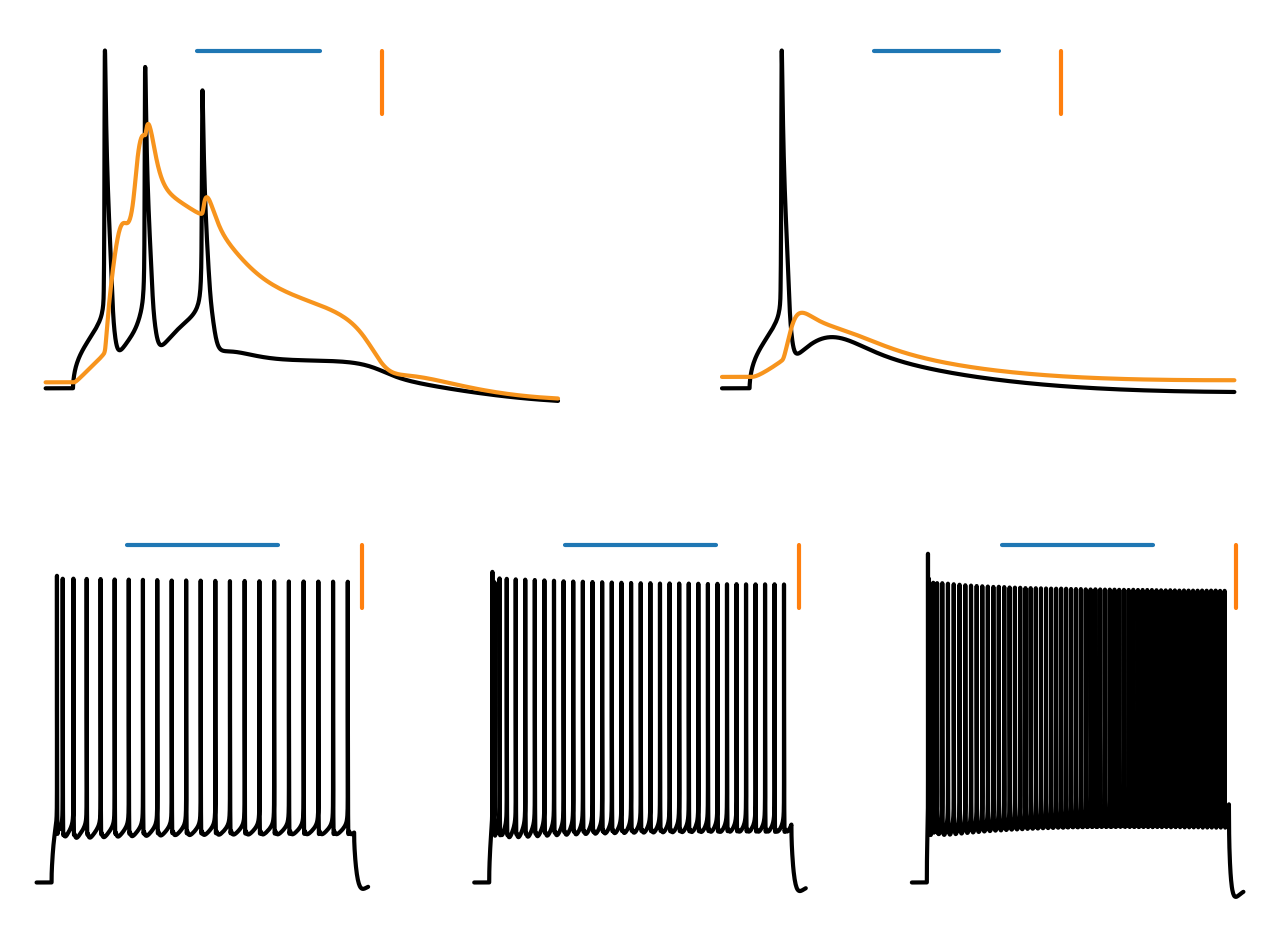

In [31]:
# visualize all responses
from visualize import voltage_trace_visualizer as vtv
vtv.visualize_vt(voltage_traces)

These responses *look* good, but *looking* is not a great quantifier. Let's see how far off these responses are compared to the empirically recored ones in the next tutorial: [1.2 Evaluation](./1.2%20Evaluation.ipynb).